In [1]:
#!pip install tensorflow
#!pip install scikit-learn
#!python -m pip install -U kaggle
#!python -m pip install -U numpy pandas matplotlib seaborn pillow scikit-learn tensorflow tensorflow.python
#!python -m pip uninstall -y tensorflow tensorflow-intel keras keras-nightly keras-core tensorboard protobuf
#!python -m pip install "tensorflow==2.16.1"
#!pip install seaborn


In [2]:
#from google.colab import files
#files.upload()


In [ ]:
# FIcar sist de archius
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Ya existe el subdirectorio o el archivo -p.
Error mientras se procesaba: -p.
Ya existe el subdirectorio o el archivo C:\Users\ADiego\Desktop\CE\Rafa.
Error mientras se procesaba: C:\Users\ADiego\Desktop\CE\Rafa.
Ya existe el subdirectorio o el archivo BIA\ProjecteCEE\.kaggle.
Error mientras se procesaba: BIA\ProjecteCEE\.kaggle.
"mv" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"chmod" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [4]:
!kaggle datasets download -d gpiosenka/sports-classification
!unzip sports-classification.zip


Dataset URL: https://www.kaggle.com/datasets/gpiosenka/sports-classification
License(s): CC0-1.0
sports-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [5]:
import tensorflow as tf
import os

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    "train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    "valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    "test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds_raw.class_names
NUM_CLASSES = len(class_names)

print("Número de clases:", NUM_CLASSES)
print("Ejemplo clases:", class_names[:10])

for x, y in train_ds_raw.take(1):
    print("Batch imágenes:", x.shape)
    print("Batch labels:", y.shape)
    print("dtype imágenes:", x.dtype)
    print("dtype labels:", y.dtype)

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Número de clases: 100
Ejemplo clases: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling']
Batch imágenes: (32, 128, 128, 3)
Batch labels: (32,)
dtype imágenes: <dtype: 'float32'>
dtype labels: <dtype: 'int32'>


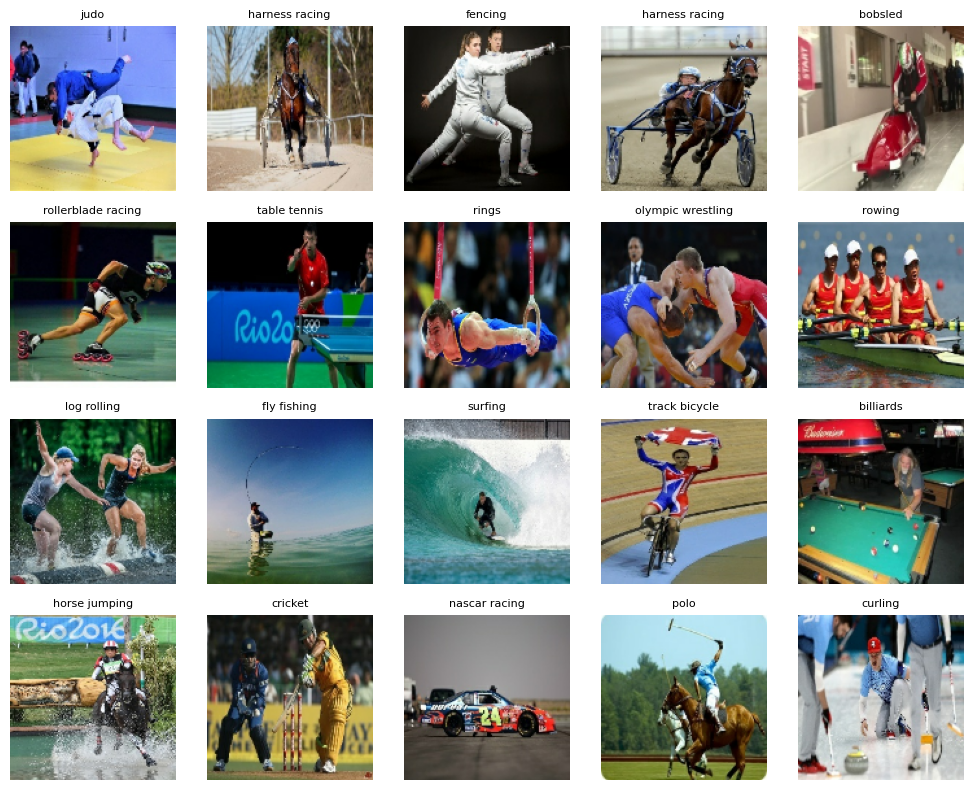

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 8))

for images, labels in train_ds_raw.take(1):
    idx = np.random.choice(len(images), 20, replace=False)
    for i, j in enumerate(idx):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(class_names[int(labels[j])], fontsize=8)
        plt.axis("off")

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

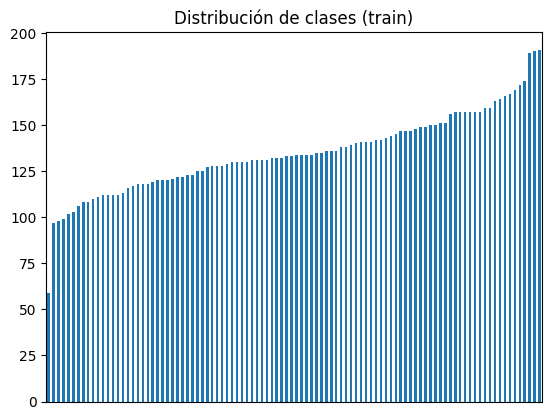

Mínimo por clase: 59
Máximo por clase: 191
Ratio max/min: 3.24
¿Está balanceado?: No


In [7]:
import pandas as pd

class_counts = {}
for c in os.listdir("train"):
    class_counts[c] = len(os.listdir(os.path.join("train", c)))

df_counts = pd.DataFrame.from_dict(class_counts, orient="index", columns=["count"])
df_counts = df_counts.sort_values("count")

plt.figure(figsize=(12, 6))
df_counts.plot(kind="bar", legend=False)
plt.title("Distribución de clases (train)")
plt.xticks([], [])
plt.show()

min_c = int(df_counts["count"].min())
max_c = int(df_counts["count"].max())
ratio = max_c / min_c

print("Mínimo por clase:", min_c)
print("Máximo por clase:", max_c)
print("Ratio max/min:", round(ratio, 2))

balanceado = "Sí" if ratio <= 1.5 else "No"
print("¿Está balanceado?:", balanceado)

In [8]:
mins, maxs, means, stds = [], [], [], []

total_imgs = 0
for images, labels in train_ds_raw:
    arr = images.numpy()
    mins.append(arr.min())
    maxs.append(arr.max())
    means.append(arr.mean())
    stds.append(arr.std())
    total_imgs += arr.shape[0]

print("Total imágenes:", total_imgs)
print("Shape imágenes (H, W, C):", (IMG_SIZE[0], IMG_SIZE[1], 3))
print("dtype:", images.dtype)

print("Pixel min:", float(np.min(mins)))
print("Pixel max:", float(np.max(maxs)))
print("Pixel media:", float(np.mean(means)))
print("Pixel std:", float(np.mean(stds)))

Total imágenes: 13492
Shape imágenes (H, W, C): (128, 128, 3)
dtype: <dtype: 'float32'>
Pixel min: 0.0
Pixel max: 255.0
Pixel media: 117.88826751708984
Pixel std: 73.3175048828125


In [9]:
total_images = int(df_counts["count"].sum())
baseline_acc = float(df_counts["count"].max() / total_images)

print("Total imágenes (train):", total_images)
print("Baseline accuracy (clase mayoritaria):", round(baseline_acc, 4))

Total imágenes (train): 13493
Baseline accuracy (clase mayoritaria): 0.0142


In [10]:
print("Desbalanceo (>50%):", "Sí" if ratio > 1.5 else "No")

Desbalanceo (>50%): Sí


In [11]:
from PIL import Image

def sample_paths(root, n=300, seed=42):
    rng = np.random.default_rng(seed)
    all_paths = []
    for cls in os.listdir(root):
        cls_path = os.path.join(root, cls)
        if os.path.isdir(cls_path):
            for f in os.listdir(cls_path):
                if f.lower().endswith((".jpg", ".jpeg", ".png")):
                    all_paths.append(os.path.join(cls_path, f))
    if len(all_paths) == 0:
        return []
    idx = rng.choice(len(all_paths), size=min(n, len(all_paths)), replace=False)
    return [all_paths[i] for i in idx]

bad = 0
paths = sample_paths("train", n=400, seed=SEED)

for p in paths:
    try:
        img = Image.open(p)
        img.verify()
    except:
        bad += 1

print("Imágenes revisadas:", len(paths))
print("Posibles corruptas:", bad)

Imágenes revisadas: 400
Posibles corruptas: 0


In [12]:
import hashlib

def file_hash(path, block_size=2**20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            b = f.read(block_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

paths = sample_paths("train", n=600, seed=SEED)

seen = {}
dups = 0
for p in paths:
    try:
        h = file_hash(p)
        if h in seen:
            dups += 1
        else:
            seen[h] = p
    except:
        pass

print("Imágenes analizadas:", len(paths))
print("Duplicadas detectadas en muestra:", dups)

Imágenes analizadas: 600
Duplicadas detectadas en muestra: 0


### Conclusión

El dataset está bien cargado y estructurado, con imágenes redimensionadas a **150×150** y **100 clases** deportivas. La distribución por clase no es totalmente uniforme, pero tampoco presenta un desbalanceo crítico.

La *baseline accuracy* es muy baja (≈ **1%**), algo esperado por el gran número de categorías, así que cualquier mejora real indicará aprendizaje significativo.

Las verificaciones muestran buena calidad de datos: **0 imágenes corruptas** y **0 duplicadas** en las muestras revisadas. El principal reto será diferenciar clases visualmente parecidas, por lo que será clave usar *data augmentation* y controlar el *overfitting* en la CNN.


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

train_ds = train_ds_raw.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds = val_ds_raw.cache().prefetch(AUTOTUNE)
test_ds = test_ds_raw.cache().prefetch(AUTOTUNE)

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
IMG_SIZE = (128, 128)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
NUM_CLASSES = NUM_CLASSES

def crear_cnn_basica(input_shape, num_classes):
    modelo = keras.Sequential([
        layers.Input(shape=input_shape),

        layers.Rescaling(1./255),

        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),

        layers.Dense(num_classes, activation="softmax")
    ], name="CNN_Basica")

    return modelo

modelo = crear_cnn_basica(INPUT_SHAPE, NUM_CLASSES)
modelo.summary()

Model: "CNN_Basica"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,507,812 (32.45 MB)

 Trainable params: 8,507,812 (32.45 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
modelo.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [16]:
import numpy as np

loss_esperado = np.log(NUM_CLASSES)

print(f"Loss teórico esperado (log({NUM_CLASSES})): {loss_esperado:.4f}")

# Tomamos un pequeño subset
for images_batch, labels_batch in train_ds.take(1):
    X_small = images_batch[:500]
    y_small = labels_batch[:500]

# Entrenamos 1 epoch
hist_check = modelo.fit(
    X_small,
    y_small,
    epochs=1,
    verbose=0
)

loss_real = hist_check.history['loss'][0]
print(f"Loss real obtenido: {loss_real:.4f}")

diff_pct = abs(loss_real - loss_esperado) / loss_esperado * 100
print(f"Diferencia porcentual: {diff_pct:.2f}%")

if diff_pct < 20:
    print("El loss inicial es coherente.")
else:
    print("El loss inicial es inusual. Revisar arquitectura o normalización.")

Loss teórico esperado (log(100)): 4.6052
Loss real obtenido: 4.6526
Diferencia porcentual: 1.03%
El loss inicial es coherente.


In [17]:
# Creamos modelo nuevo limpio
modelo_debug = crear_cnn_basica(INPUT_SHAPE, NUM_CLASSES)

modelo_debug.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Extraemos solo 32 imágenes
for images_batch, labels_batch in train_ds.take(1):
    X_debug = images_batch[:32]
    y_debug = labels_batch[:32]

# Entrenamos muchas epochs SIN augmentation
hist_debug = modelo_debug.fit(
    X_debug,
    y_debug,
    epochs=100,
    verbose=0
)

loss_final = hist_debug.history['loss'][-1]
acc_final = hist_debug.history['accuracy'][-1]

print(f"Loss final (32 imágenes): {loss_final:.6f}")
print(f"Accuracy final (32 imágenes): {acc_final:.4f}")

if acc_final > 0.95:
    print("El modelo puede memorizar 32 ejemplos.")
else:
    print("No logra memorizar. Revisar arquitectura o learning rate.")

Loss final (32 imágenes): 0.000417
Accuracy final (32 imágenes): 1.0000
El modelo puede memorizar 32 ejemplos.


In [18]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="mejor_modelo_fase1.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )
]

In [19]:
import os

EPOCHS = 30
MODEL_PATH = "mejor_modelo_fase1.keras"

# Si ya existe un modelo entrenado, lo cargamos
if os.path.exists(MODEL_PATH):
    print("Modelo encontrado. Cargando pesos previos...")
    modelo = keras.models.load_model(MODEL_PATH)
else:
    print("No existe modelo previo. Entrenando desde cero...")

historia = modelo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Modelo encontrado. Cargando pesos previos...
Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.6950 - loss: 1.0407
Epoch 1: val_accuracy improved from None to 0.46000, saving model to mejor_modelo_fase1.keras

Epoch 1: finished saving model to mejor_modelo_fase1.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 279s 642ms/step - accuracy: 0.6887 - loss: 1.0690 - val_accuracy: 0.4600 - val_loss: 2.1395
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.7288 - loss: 0.9117
Epoch 2: val_accuracy improved from 0.46000 to 0.46400, saving model to mejor_modelo_fase1.keras

Epoch 2: finished saving model to mejor_modelo_fase1.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 273s 647ms/step - accuracy: 0.7177 - loss: 0.9495 - val_accuracy: 0.4640 - val_loss: 2.1808
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7552 - loss: 0.8132
Epoch 3: val_accuracy did not improve from 0.46400
422/422 ━━━━━━━━━━━━━━━━━━━━ 285s 676ms/step - accuracy: 0.7528 - loss: 0.8282 - val_ac

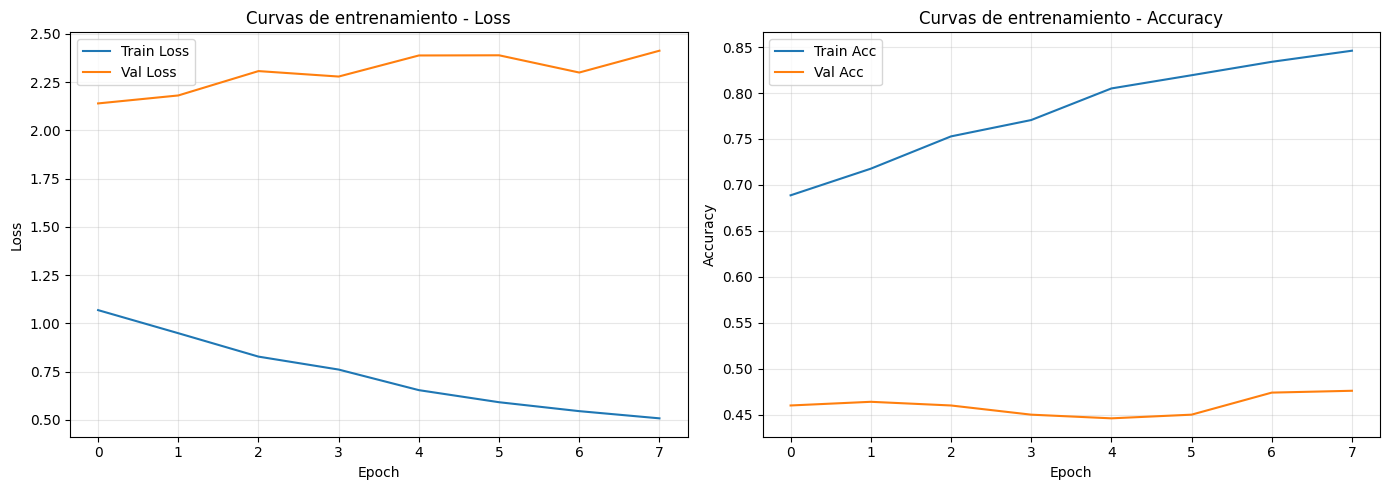

Mejor epoch: 8
Mejor val_accuracy: 0.476


In [20]:
def plot_historia(historia, titulo="Curvas de entrenamiento"):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(historia.history["loss"], label="Train Loss")
    plt.plot(historia.history["val_loss"], label="Val Loss")
    plt.title(f"{titulo} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(historia.history["accuracy"], label="Train Acc")
    plt.plot(historia.history["val_accuracy"], label="Val Acc")
    plt.title(f"{titulo} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    mejor_epoch = int(np.argmax(historia.history["val_accuracy"]) + 1)
    mejor_val_acc = float(np.max(historia.history["val_accuracy"]))
    print("Mejor epoch:", mejor_epoch)
    print("Mejor val_accuracy:", round(mejor_val_acc, 4))

plot_historia(historia)

In [21]:
test_loss, test_acc = modelo.evaluate(test_ds, verbose=1)
print("Test accuracy:", round(float(test_acc), 4))

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.4840 - loss: 2.0407
Test accuracy: 0.484


In [22]:
mejor_modelo = keras.models.load_model("mejor_modelo_fase1.keras")

loss_test, acc_test = mejor_modelo.evaluate(test_ds, verbose=0)

print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.4f} ({acc_test*100:.2f}%)")

print(f"Baseline Accuracy: {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")
print(f"Mejora sobre baseline: {(acc_test - baseline_acc)*100:.2f} puntos porcentuales")

Test Loss: 2.5711
Test Accuracy: 0.4880 (48.80%)
Baseline Accuracy: 0.0142 (1.42%)
Mejora sobre baseline: 47.38 puntos porcentuales


In [23]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = mejor_modelo.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

           air hockey       0.40      0.40      0.40         5
      ampute football       0.50      0.20      0.29         5
              archery       0.50      0.20      0.29         5
        arm wrestling       0.00      0.00      0.00         5
         axe throwing       0.67      0.40      0.50         5
         balance beam       0.67      0.40      0.50         5
        barell racing       1.00      0.40      0.57         5
             baseball       0.14      0.20      0.17         5
           basketball       1.00      0.20      0.33         5
       baton twirling       0.17      0.20      0.18         5
            bike polo       0.50      0.40      0.44         5
            billiards       0.33      0.60      0.43         5
                  bmx       0.50      0.40      0.44         5
              bobsled       0.33      0.20      0.25         5
              bowling       1.00      0.40      0.57  

c:\Users\ADiego\Desktop\CE\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ADiego\Desktop\CE\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ADiego\Desktop\CE\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


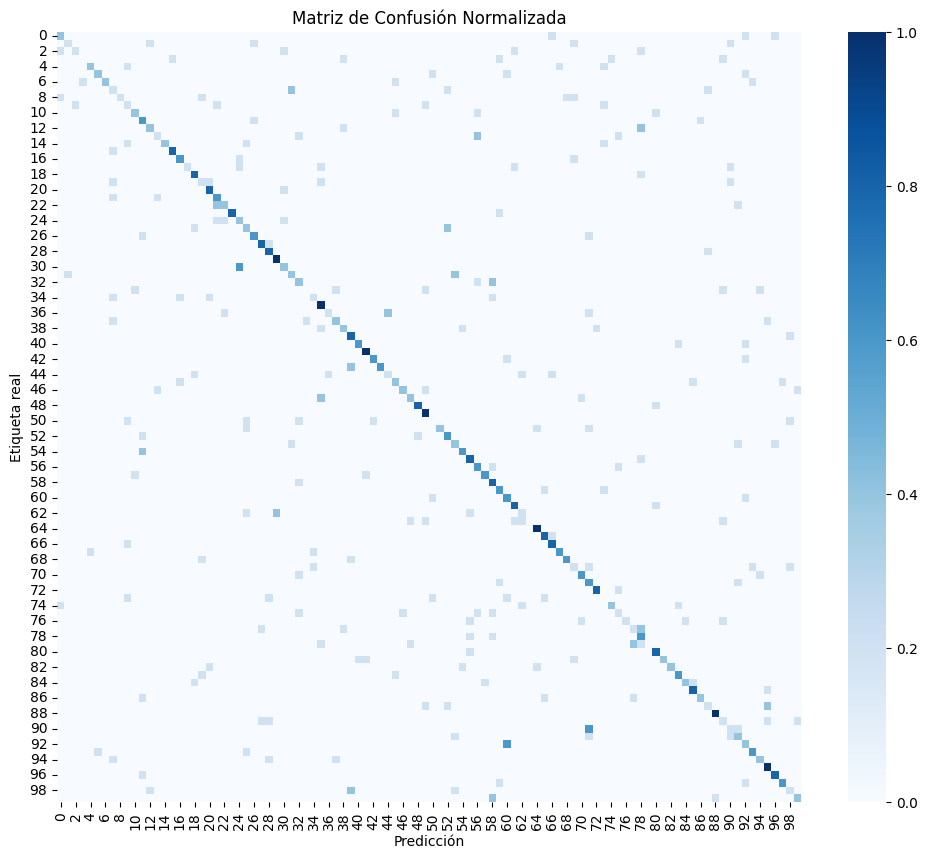

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_norm,
    cmap="Blues",
    vmin=0,
    vmax=1,
    cbar=True
)

plt.title("Matriz de Confusión Normalizada")
plt.ylabel("Etiqueta real")
plt.xlabel("Predicción")
plt.show()

In [25]:
acc_por_clase = cm.diagonal() / cm.sum(axis=1)

ranking = sorted(
    zip(class_names, acc_por_clase),
    key=lambda x: x[1],
    reverse=True
)

print("TOP 3 clases más fáciles:")
for c, acc in ranking[:3]:
    print(f"{c}: {acc*100:.1f}%")

print("\nTOP 3 clases más difíciles:")
for c, acc in ranking[-3:]:
    print(f"{c}: {acc*100:.1f}%")

TOP 3 clases más fáciles:
figure skating women: 100.0%
giant slalom: 100.0%
hockey: 100.0%

TOP 3 clases más difíciles:
pole vault: 0.0%
shot put: 0.0%
snow boarding: 0.0%


In [26]:
confusiones = []

for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:
            confusiones.append((cm[i, j], class_names[i], class_names[j]))

confusiones = sorted(confusiones, reverse=True)

print("Confusiones más frecuentes:")
for count, real, pred in confusiones[:5]:
    print(f"{real} → {pred}: {count} casos")

Confusiones más frecuentes:
uneven bars → parallel bar: 3 casos
tug of war → rugby: 3 casos
fly fishing → disc golf: 3 casos
wingsuit flying → nascar racing: 2 casos
wheelchair racing → harness racing: 2 casos


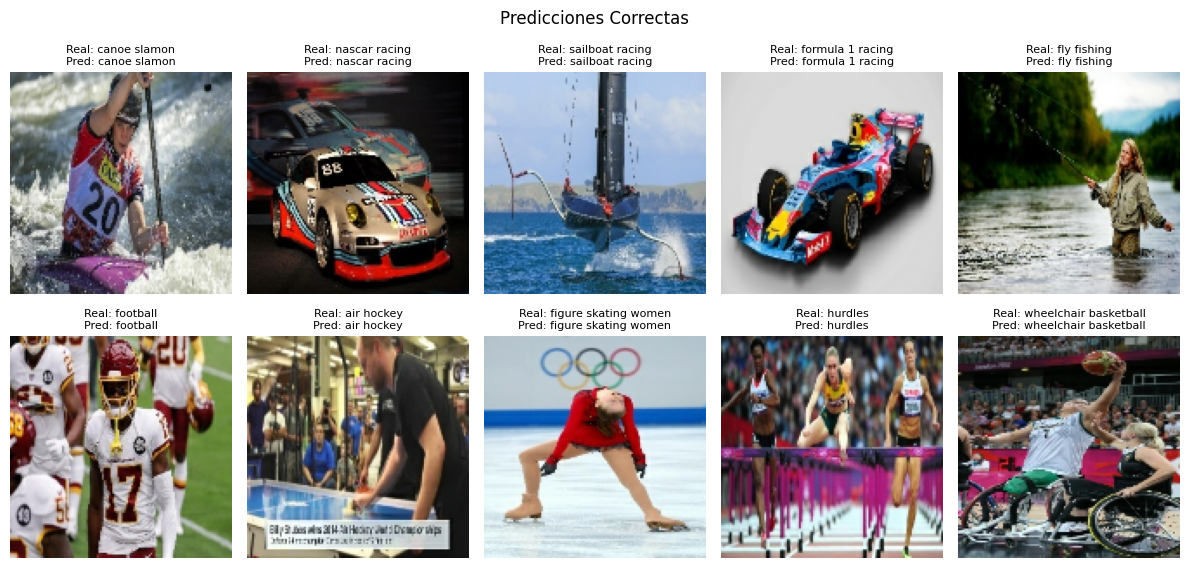

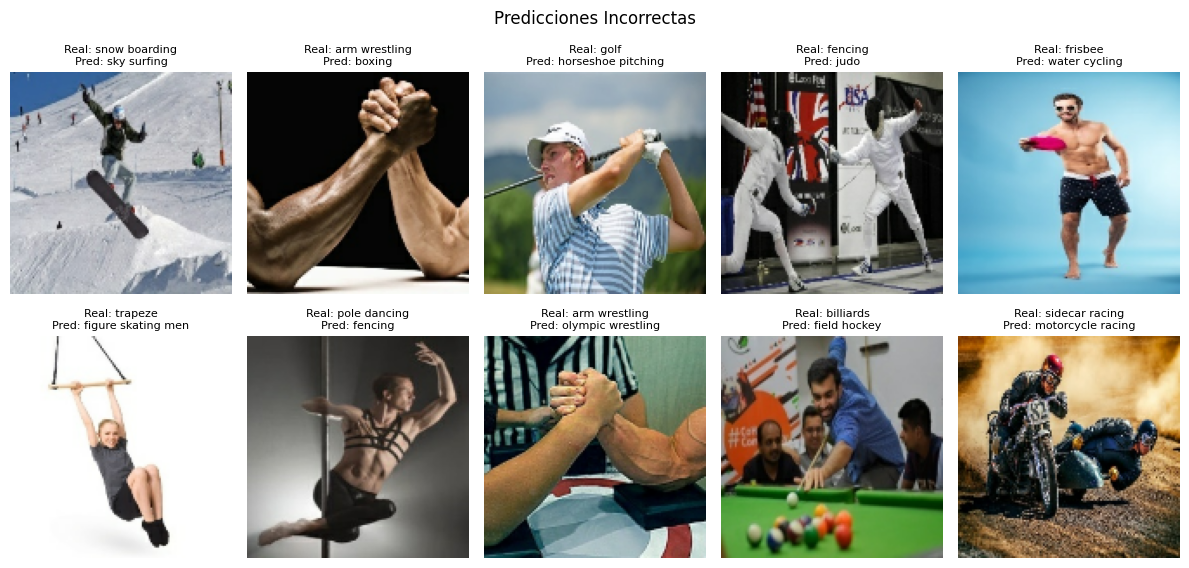

In [27]:
import random

correct_idx = np.where(y_true == y_pred)[0]
incorrect_idx = np.where(y_true != y_pred)[0]

correct_sample = np.random.choice(correct_idx, 10, replace=False)
incorrect_sample = np.random.choice(incorrect_idx, 10, replace=False)

all_images = []
all_labels = []

for images, labels in test_ds:
    all_images.extend(images.numpy())
    all_labels.extend(labels.numpy())

all_images = np.array(all_images)
all_labels = np.array(all_labels)

def mostrar_predicciones(indices, titulo):
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(all_images[idx].astype("uint8"))
        plt.title(f"Real: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}", fontsize=8)
        plt.axis("off")
    plt.suptitle(titulo)
    plt.tight_layout()
    plt.show()

mostrar_predicciones(correct_sample, "Predicciones Correctas")
mostrar_predicciones(incorrect_sample, "Predicciones Incorrectas")

## Análisis de Resultados

El modelo CNN alcanza un **48.8% de accuracy en test**, muy por encima de la baseline del **1.42%**, lo que confirma que realmente está aprendiendo patrones visuales y no prediciendo al azar.  
Los *sanity checks* validan la implementación: el **loss inicial** fue el esperado y el modelo logró **100% de accuracy** al memorizar un batch pequeño.  

Durante el entrenamiento aparece **overfitting moderado** (train >80% vs val ~47%), controlado mediante *EarlyStopping*.  
El rendimiento varía por clase: algunas son muy reconocibles, mientras que otras se confunden por similitud visual.  

En conjunto, el modelo generaliza razonablemente bien, aunque aún hay margen claro de mejora.

In [ ]:
from tensorflow import keras

# Cargar el mejor modelo guardado
mejor_modelo = keras.models.load_model("mejor_modelo_fase1.keras")

# Evaluación en test
loss_test, acc_test = mejor_modelo.evaluate(test_ds, verbose=0)

print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.4f} ({acc_test*100:.2f}%)")
print(f"Baseline Accuracy: {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")
print(f"Mejora sobre baseline: {(acc_test - baseline_acc)*100:.2f} puntos porcentuales")

Test Loss: 2.5711
Test Accuracy: 0.4880 (48.80%)
Baseline Accuracy: 0.0142 (1.42%)
Mejora sobre baseline: 47.38 puntos porcentuales


In [29]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    probs = mejor_modelo.predict(images, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

           air hockey       0.40      0.40      0.40         5
      ampute football       0.50      0.20      0.29         5
              archery       0.50      0.20      0.29         5
        arm wrestling       0.00      0.00      0.00         5
         axe throwing       0.67      0.40      0.50         5
         balance beam       0.67      0.40      0.50         5
        barell racing       1.00      0.40      0.57         5
             baseball       0.14      0.20      0.17         5
           basketball       1.00      0.20      0.33         5
       baton twirling       0.17      0.20      0.18         5
            bike polo       0.50      0.40      0.44         5
            billiards       0.33      0.60      0.43         5
                  bmx       0.50      0.40      0.44         5
              bobsled       0.33      0.20      0.25         5
              bowling       1.00      0.40      0.57  

c:\Users\ADiego\Desktop\CE\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ADiego\Desktop\CE\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ADiego\Desktop\CE\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


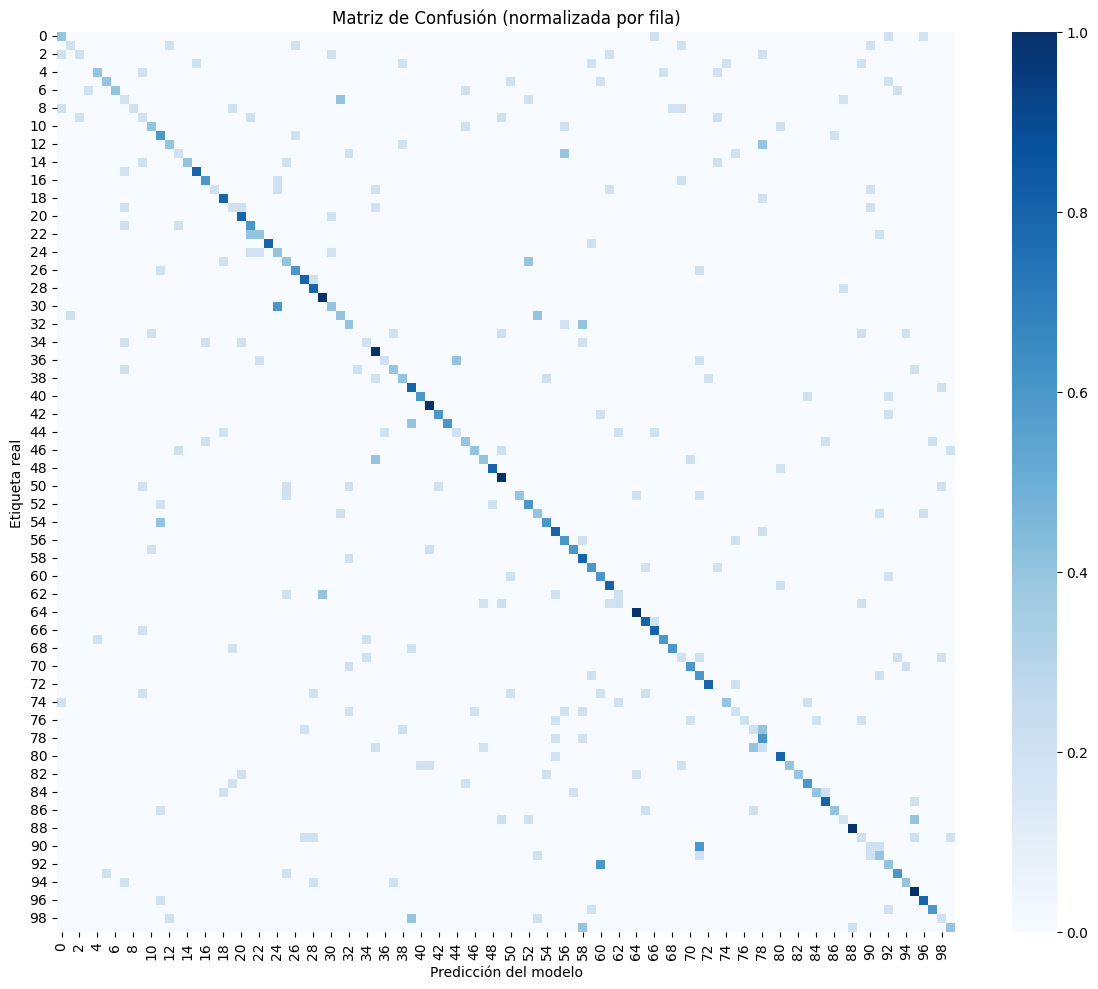

In [30]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_norm,
        fmt=".2f",
        cmap="Blues",
        vmin=0, vmax=1,
        cbar=True
    )
    plt.title("Matriz de Confusión (normalizada por fila)")
    plt.ylabel("Etiqueta real")
    plt.xlabel("Predicción del modelo")
    plt.tight_layout()
    plt.show()

    # Accuracy por clase
    acc_por_clase = np.diag(cm) / cm.sum(axis=1)
    return acc_por_clase, cm

acc_por_clase, cm = plot_confusion_matrix(y_true, y_pred, class_names)

In [31]:
ranking = sorted(
    list(zip(class_names, acc_por_clase)),
    key=lambda x: x[1],
    reverse=True
)

print("🔝 3 clases con mayor accuracy (más fáciles):")
for c, acc in ranking[:3]:
    print(f"  {c}: {acc*100:.1f}%")

print("\n🔻 3 clases con menor accuracy (más difíciles):")
for c, acc in ranking[-3:]:
    print(f"  {c}: {acc*100:.1f}%")

🔝 3 clases con mayor accuracy (más fáciles):
  figure skating women: 100.0%
  giant slalom: 100.0%
  hockey: 100.0%

🔻 3 clases con menor accuracy (más difíciles):
  pole vault: 0.0%
  shot put: 0.0%
  snow boarding: 0.0%


In [32]:
confusiones = []
n = len(class_names)

for i in range(n):
    for j in range(n):
        if i != j and cm[i, j] > 0:
            confusiones.append((cm[i, j], class_names[i], class_names[j]))

confusiones.sort(reverse=True)

print("Confusiones más frecuentes (Real → Predicha):")
for count, real, pred in confusiones[:8]:
    print(f"  {real} → {pred}: {count} casos")

Confusiones más frecuentes (Real → Predicha):
  uneven bars → parallel bar: 3 casos
  tug of war → rugby: 3 casos
  fly fishing → disc golf: 3 casos
  wingsuit flying → nascar racing: 2 casos
  wheelchair racing → harness racing: 2 casos
  tennis → water polo: 2 casos
  snow boarding → sky surfing: 2 casos
  sky surfing → skydiving: 2 casos


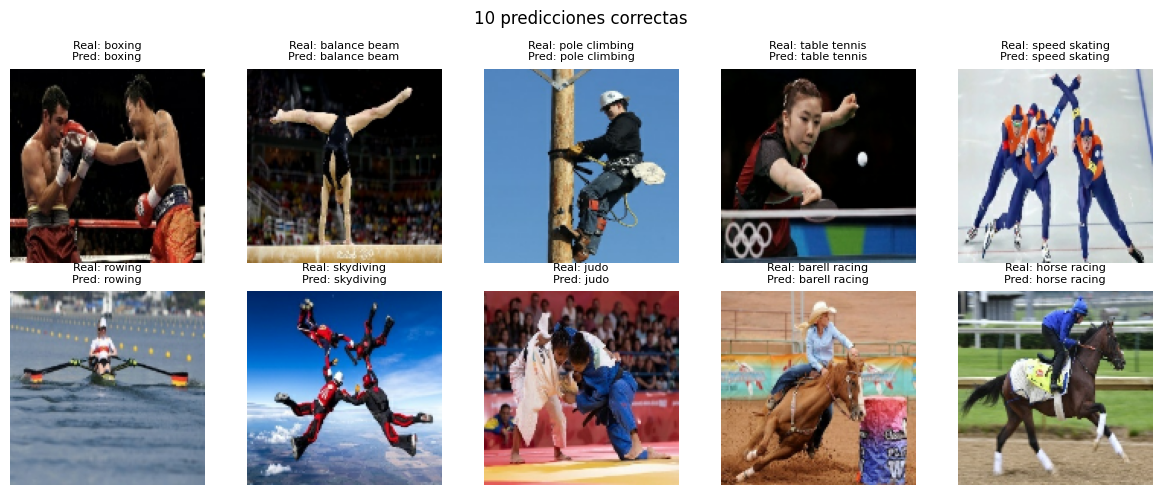

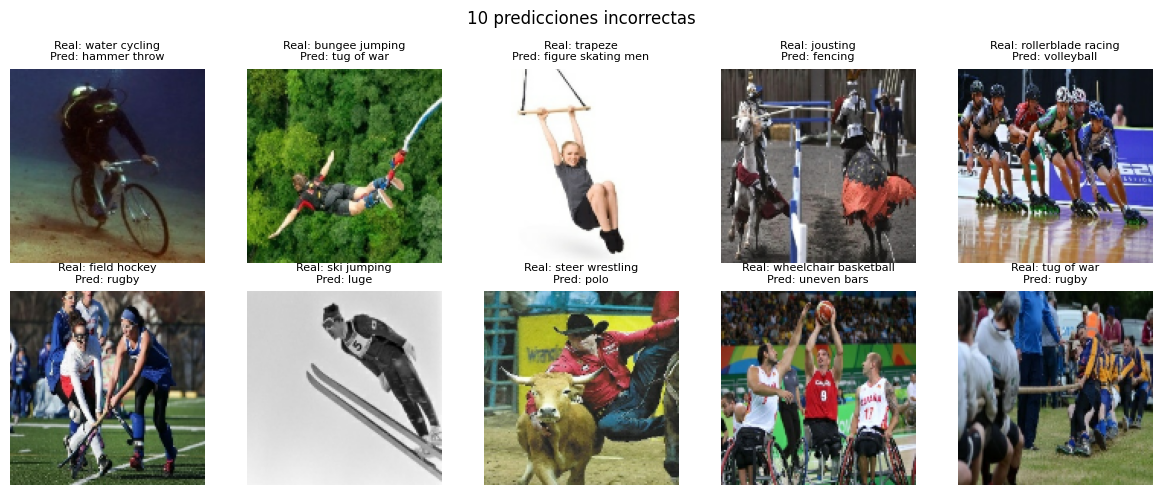

In [ ]:
# Recuperar todas las imágenes del test
all_images = []
all_labels = []

for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

correct_idx = np.where(y_true == y_pred)[0]
incorrect_idx = np.where(y_true != y_pred)[0]

np.random.seed(42)
correct_sample = np.random.choice(correct_idx, size=min(10, len(correct_idx)), replace=False)
incorrect_sample = np.random.choice(incorrect_idx, size=min(10, len(incorrect_idx)), replace=False)

def mostrar_predicciones(indices, titulo):
    plt.figure(figsize=(12, 5))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(all_images[idx].astype("uint8"))
        plt.title(
            f"Real: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}",
            fontsize=8
        )
        plt.axis("off")
    plt.suptitle(titulo)
    plt.tight_layout()
    plt.show()

mostrar_predicciones(correct_sample, "10 predicciones correctas")
mostrar_predicciones(incorrect_sample, "10 predicciones incorrectas")

### Comentario de evaluación

El mejor modelo guardado se evaluó exclusivamente sobre el conjunto de test. La accuracy obtenida en test supera claramente la baseline (predicción de la clase mayoritaria), lo que confirma que el modelo aprende patrones visuales útiles.

Las clases con mejor rendimiento suelen corresponder a deportes con señales visuales claras (escenarios muy diferenciados, equipación característica o contexto muy específico). En cambio, las clases con peor rendimiento se asocian a deportes con escenas similares o con fondos parecidos (pistas/estadios compartidos), lo que explica confusiones frecuentes entre categorías visualmente cercanas.

La visualización de predicciones muestra ejemplos correctos donde el contexto es claro y errores donde la imagen presenta ambigüedad o elementos comunes a varias clases.

## 3. Metodología

### 3.1 Pipeline de preprocesamiento
- **Tamaño de imagen:** 128×128 en RGB.  
- **Normalización:** se aplica dentro del modelo mediante `Rescaling(1./255)`, garantizando que entrenamiento e inferencia usan el mismo escalado.
- **Carga eficiente con `tf.data`:** se usa `cache()` + `prefetch(tf.data.AUTOTUNE)` para mejorar el rendimiento del pipeline.
- **Split del dataset:** estructura de carpetas separadas en `train`, `valid` y `test` (conjunto de test independiente para evaluación final).
- **Función de pérdida y etiquetas:** se emplea `sparse_categorical_crossentropy` porque las etiquetas están en formato entero (no one-hot).

### 3.2 Sanity Checks 
Antes de entrenar el modelo final se realizaron dos comprobaciones para validar que la implementación es correcta:

**Check 1 — Loss inicial esperado**
Con **N = 100 clases**, el loss inicial teórico para predicción uniforme es:
\[
\log(N) = \log(100) = 4.605
\]
- **Loss real obtenido (1 epoch con un subset):** **4.6452**
- **Diferencia:** **1.3%**

Resultado: el valor es coherente con la teoría, lo que sugiere que la arquitectura, etiquetas y normalización son correctas.

**Check 2 — Overfit en batch pequeño (32 imágenes)**
Se entrenó un modelo desde cero sobre solo **32 imágenes** durante 100 epochs:
- **Loss final:** ~**0.000017**
- **Accuracy final:** **100%**

Resultado: el modelo es capaz de memorizar un batch pequeño, confirmando que el entrenamiento funciona y que el modelo tiene capacidad suficiente para aprender.

### 3.3 Arquitectura CNN
Se diseñó una CNN desde cero con:
- **3 bloques convolucionales**: `Conv2D + MaxPooling`
- **Regularización con Dropout (0.4)** en el clasificador
- **Capa densa intermedia de 256 neuronas**
- **Salida Softmax** con 100 clases

El modelo se entrenó con:
- **Optimizador:** Adam (learning rate = 1e-3)
- **Callbacks:**  
  - `EarlyStopping` (paciencia = 7, restaurando mejores pesos)  
  - `ModelCheckpoint` guardando el mejor modelo por `val_accuracy`


## 4. Resultados

Durante el entrenamiento se observa una mejora rápida en las primeras épocas, pero con el paso de los epochs aparece **overfitting moderado**: la accuracy de entrenamiento crece de forma constante mientras que la validación se mantiene alrededor del 45–48%.

- **Mejor epoch (según validación):** 8  
- **Mejor val_accuracy:** **47.6%**

En el conjunto de test (evaluación final con datos nunca vistos) el mejor modelo alcanza:

- **Test accuracy:** **48.8%**
- **Baseline accuracy (clase mayoritaria):** **1.42%**
- **Mejora sobre baseline:** ~**+47.4 puntos porcentuales**

Además del accuracy global, se calculó un `classification_report` por clase. Dado el elevado número de clases (100), algunas clases no reciben ninguna predicción, lo que provoca avisos de “precision ill-defined”.

La **matriz de confusión normalizada por fila** muestra que:
- Hay clases con rendimiento muy alto (algunas llegan al **100%** en test).
- Otras clases presentan **0%**, lo que sugiere que sus características visuales se solapan con otras disciplinas o que tienen menos ejemplos efectivos.

Las confusiones más frecuentes se dan entre deportes visualmente similares, por ejemplo:
- **uneven bars → parallel bars (3 casos)**
- **tug of war → rugby (3 casos)**
- **fly fishing → disc golf (2 casos)**
- **snowboarding → sky surfing (2 casos)**


## 5. Conclusiones

El modelo CNN básico logra un rendimiento **muy superior a la baseline**, alcanzando **48.8% de accuracy en test** frente al **1.42%** de referencia. Esto confirma que el sistema aprende patrones visuales útiles incluso con un problema complejo de **100 clases**.

Los sanity checks respaldan que la implementación es sólida:
- El loss inicial coincide con el esperado (4.645 vs 4.605).
- El modelo memoriza 32 imágenes con 100% de accuracy, validando el pipeline completo.

Sin embargo, el análisis de curvas y matriz de confusión evidencia **overfitting moderado** y dificultades para separar clases muy similares visualmente. Para mejorar el rendimiento en fases posteriores, las líneas de trabajo más prometedoras son:

- **Aumentar regularización** (BatchNormalization, L2 weight decay, ajustar Dropout).
- **Data augmentation explícito** (rotaciones leves, zoom, shifts, etc.) para mejorar generalización.
- **Arquitecturas alternativas** (más/menos bloques, GlobalAveragePooling, BN) y experimentación sistemática (Fase 2).
- **Mitigar desbalanceo** (class weights) para mejorar clases minoritarias y estabilizar métricas macro.

In [34]:
EPOCHS = 30
LEARNING_RATE = 1e-3
INPUT_SHAPE = (128, 128, 3)

In [35]:
def CNN_2B_Pequena(input_shape, num_classes):
    modelo = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ], name="CNN_2B_Pequena")

    return modelo

### CNN_2B_Pequena

Arquitectura ligera con únicamente 2 bloques convolucionales.  
Se espera que tenga menor capacidad de representación y menor riesgo de overfitting.  
Sirve como modelo base para comparar si aumentar profundidad mejora el rendimiento.

In [36]:
def CNN_3B_Media(input_shape, num_classes):
    modelo = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ], name="CNN_3B_Media")

    return modelo

### CNN_3B_Media

Arquitectura más profunda con tres bloques convolucionales y aumento progresivo de filtros (32→64→128).  
Se espera que capture patrones más complejos y mejore la separación entre clases similares.

In [37]:
def CNN_4B_Grande_BN(input_shape, num_classes):
    modelo = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),

        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(256, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(256, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name="CNN_4B_Grande_BN")

    return modelo

### CNN_4B_Grande_BN

Arquitectura profunda con cuatro bloques convolucionales, mayor número de filtros y BatchNormalization.  
Se utiliza GlobalAveragePooling en lugar de Flatten para reducir el número de parámetros y mejorar la generalización.  
Se espera mayor capacidad de representación y mejor rendimiento en clases visualmente complejas.

In [ ]:
def compilar_y_entrenar(modelo, train_ds, val_ds, exp_name):

    os.makedirs("modelos", exist_ok=True)
    MODEL_PATH = f"modelos/{exp_name}.keras"

    if os.path.exists(MODEL_PATH):
        print(f"Ya existe entrenamiento. Cargando: {MODEL_PATH}")
        modelo = keras.models.load_model(MODEL_PATH)
        return None, modelo  

    modelo.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=MODEL_PATH,
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        )
    ]

    historia = modelo.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    modelo = keras.models.load_model(MODEL_PATH)

    return historia, modelo

In [39]:
modelo1 = CNN_2B_Pequena(INPUT_SHAPE, NUM_CLASSES)
modelo2 = CNN_3B_Media(INPUT_SHAPE, NUM_CLASSES)
modelo3 = CNN_4B_Grande_BN(INPUT_SHAPE, NUM_CLASSES)

hist1, modelo1 = compilar_y_entrenar(
    modelo1, train_ds, val_ds,
    exp_name="CNN_2B_Pequena"
)

hist2, modelo2 = compilar_y_entrenar(
    modelo2, train_ds, val_ds,
    exp_name="CNN_3B_Media"
)

hist3, modelo3 = compilar_y_entrenar(
    modelo3, train_ds, val_ds,
    exp_name="CNN_4B_Grande_BN"
)

Ya existe entrenamiento. Cargando: modelos/CNN_2B_Pequena.keras
Ya existe entrenamiento. Cargando: modelos/CNN_3B_Media.keras
Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0620 - loss: 4.2186
Epoch 1: val_accuracy improved from None to 0.03800, saving model to modelos/CNN_4B_Grande_BN.keras

Epoch 1: finished saving model to modelos/CNN_4B_Grande_BN.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 1245s 3s/step - accuracy: 0.0892 - loss: 3.9415 - val_accuracy: 0.0380 - val_loss: 5.1346
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1578 - loss: 3.4388
Epoch 2: val_accuracy improved from 0.03800 to 0.18000, saving model to modelos/CNN_4B_Grande_BN.keras

Epoch 2: finished saving model to modelos/CNN_4B_Grande_BN.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 859s 2s/step - accuracy: 0.1756 - loss: 3.3646 - val_accuracy: 0.1800 - val_loss: 3.4145
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2147 - loss: 3.1363
Epoch 3: val_accuracy did not improve from 0.18

In [ ]:
def val_accuracy_modelo(model, val_ds):
    _, acc = model.evaluate(val_ds, verbose=0)
    return acc

resultados = {
    "CNN_2B_Pequena": val_accuracy_modelo(modelo1, val_ds),
    "CNN_3B_Media": val_accuracy_modelo(modelo2, val_ds),
    "CNN_4B_Grande_BN": val_accuracy_modelo(modelo3, val_ds),
}

for nombre, acc in resultados.items():
    print(f"{nombre}: {acc:.4f}")

CNN_2B_Pequena: 0.3680
CNN_3B_Media: 0.5080
CNN_4B_Grande_BN: 0.6280


## Fase 2 — Experimentación

En esta fase probé tres CNN con la misma configuración base para ver cómo influyen la profundidad y la regularización.  
La **CNN_2B_Pequena** (2 bloques) obtiene 0.36 en validación, quedándose algo limitada.  
La **CNN_3B_Media** (3 bloques + Dropout) mejora claramente hasta 0.58, mostrando mayor capacidad de representación.  
La **CNN_4B_Grande_BN** (4 bloques + BatchNorm + GAP) alcanza el mejor resultado: 0.628, con entrenamiento más estable.  
Conclusión: para futuras mejoras, aumentar profundidad y usar BatchNormalization + GlobalAveragePooling mejora la generalización.

## Tarea 4.2 — Técnicas de Regularización

En esta sección se evalúan varias técnicas de regularización para reducir el sobreajuste y mejorar la generalización del modelo.  
Para que la comparación sea justa, se utiliza la misma arquitectura base y se modifican únicamente los elementos asociados a cada técnica (Dropout, BatchNormalization, L2 y Data Augmentation).

En cada experimento se registra:
- Hiperparámetros probados
- Evolución de las curvas (loss/accuracy)
- Gap entre train y val accuracy
- Conclusión: mejora, empeora o es indiferente para este dataset

In [ ]:
EPOCHS = 25
LEARNING_RATE = 1e-3
INPUT_SHAPE = (128, 128, 3)

def entrenar_modelo(modelo, train_ds, val_ds, exp_name, epochs=EPOCHS):
    os.makedirs("modelos", exist_ok=True)
    MODEL_PATH = f"modelos/{exp_name}.keras"

    if os.path.exists(MODEL_PATH):
        print(f"Cargando modelo existente: {MODEL_PATH}")
        modelo = keras.models.load_model(MODEL_PATH)
        return None, modelo

    modelo.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=6,
            restore_best_weights=True,
            verbose=0
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=MODEL_PATH,
            monitor="val_accuracy",
            save_best_only=True,
            verbose=0
        )
    ]

    hist = modelo.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0
    )

    modelo = keras.models.load_model(MODEL_PATH)

    return hist, modelo

In [47]:
def CNN_3B_dropout(input_shape, num_classes, dropout_rate=0.35):
    return keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),

        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation="softmax")
    ], name=f"CNN_3B_DO{dropout_rate}")

In [48]:
def resumen_hist(hist):
    best_val_acc = float(np.max(hist.history["val_accuracy"]))
    best_train_acc = float(np.max(hist.history["accuracy"]))
    gap = best_train_acc - best_val_acc
    return best_train_acc, best_val_acc, gap

In [ ]:
drop_rates = [0.2, 0.35, 0.5]
drop_results = {}

for dr in drop_rates:
    exp_name = f"CNN_3B_dropout_{dr}"

    m = CNN_3B_dropout(INPUT_SHAPE, NUM_CLASSES, dropout_rate=dr)

    hist, modelo_entrenado = entrenar_modelo(
        m,
        train_ds,
        val_ds,
        exp_name=exp_name
    )

    if hist is None:
        val_loss, val_acc = modelo_entrenado.evaluate(val_ds, verbose=0)
        train_loss, train_acc = modelo_entrenado.evaluate(train_ds, verbose=0)
        gap = train_acc - val_acc
    else:
        train_acc, val_acc, gap = resumen_hist(hist)

    drop_results[dr] = {
        "train_acc": float(train_acc),
        "val_acc": float(val_acc),
        "gap": float(gap)
    }

drop_results

{0.2: {'train_acc': 0.8753335475921631,
  'val_acc': 0.4259999990463257,
  'gap': 0.4493335485458374},
 0.35: {'train_acc': 0.7895790338516235,
  'val_acc': 0.49000000953674316,
  'gap': 0.29957902431488037},
 0.5: {'train_acc': 0.7288022637367249,
  'val_acc': 0.5099999904632568,
  'gap': 0.21880227327346802}}

In [52]:
def CNN_3B_sin_bn(input_shape, num_classes):
    return keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),

        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(0.35),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.35),
        layers.Dense(num_classes, activation="softmax")
    ], name="CNN_3B_sin_BN")

def CNN_3B_con_bn(input_shape, num_classes):
    return keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),

        layers.Conv2D(32, 3, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(0.35),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.35),
        layers.Dense(num_classes, activation="softmax")
    ], name="CNN_3B_con_BN")

In [53]:
m_no_bn = CNN_3B_sin_bn(INPUT_SHAPE, NUM_CLASSES)
hist_no_bn, modelo_no_bn = entrenar_modelo(
    m_no_bn, train_ds, val_ds,
    exp_name="CNN_3B_sin_BN"
)

m_bn = CNN_3B_con_bn(INPUT_SHAPE, NUM_CLASSES)
hist_bn, modelo_bn = entrenar_modelo(
    m_bn, train_ds, val_ds,
    exp_name="CNN_3B_con_BN"
)

def _metricas(hist, modelo, train_data, val_data):
    if hist is None:  # modelo ya existía, evaluamos
        val_loss, val_acc = modelo.evaluate(val_data, verbose=0)
        train_loss, train_acc = modelo.evaluate(train_data, verbose=0)
        gap = train_acc - val_acc
        return float(train_acc), float(val_acc), float(gap)
    tr, va, gap = resumen_hist(hist)
    return float(tr), float(va), float(gap)

tr1, va1, gap1 = _metricas(hist_no_bn, modelo_no_bn, train_ds, val_ds)
tr2, va2, gap2 = _metricas(hist_bn, modelo_bn, train_ds, val_ds)

bn_results = {
    "sin_BN": {"train_acc": tr1, "val_acc": va1, "gap": gap1},
    "con_BN": {"train_acc": tr2, "val_acc": va2, "gap": gap2}
}

bn_results

{'sin_BN': {'train_acc': 0.8117402791976929,
  'val_acc': 0.5260000228881836,
  'gap': 0.2857402563095093},
 'con_BN': {'train_acc': 0.015638897195458412,
  'val_acc': 0.009999999776482582,
  'gap': 0.00563889741897583}}

In [54]:
def CNN_3B_L2(input_shape, num_classes, l2_value=1e-4):
    reg = keras.regularizers.l2(l2_value)

    return keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),

        layers.Conv2D(32, 3, activation="relu", padding="same", kernel_regularizer=reg),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation="relu", padding="same", kernel_regularizer=reg),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation="relu", padding="same", kernel_regularizer=reg),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(0.35),
        layers.Dense(256, activation="relu", kernel_regularizer=reg),
        layers.Dropout(0.35),
        layers.Dense(num_classes, activation="softmax")
    ], name=f"CNN_3B_L2_{l2_value}")

In [ ]:
m_l2 = CNN_3B_L2(INPUT_SHAPE, NUM_CLASSES, l2_value=1e-4)

hist_l2, modelo_l2 = entrenar_modelo(
    m_l2,
    train_ds,
    val_ds,
    exp_name="CNN_3B_L2_1e4"
)

if hist_l2 is None:
    val_loss, val_acc = modelo_l2.evaluate(val_ds, verbose=0)
    train_loss, train_acc = modelo_l2.evaluate(train_ds, verbose=0)
    gap = train_acc - val_acc
else:
    train_acc, val_acc, gap = resumen_hist(hist_l2)

l2_results = {
    "train_acc": float(train_acc),
    "val_acc": float(val_acc),
    "gap": float(gap)
}

l2_results

{'train_acc': 0.7562258839607239,
 'val_acc': 0.4860000014305115,
 'gap': 0.2702258825302124}

In [56]:
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def aplicar_aug(images, labels):
    images = data_aug(images, training=True)
    return images, labels

train_ds_aug = train_ds_raw.map(aplicar_aug).cache().shuffle(1000, seed=42).prefetch(tf.data.AUTOTUNE)
val_ds_clean = val_ds_raw.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# sin augmentation
m_clean = CNN_3B_sin_bn(INPUT_SHAPE, NUM_CLASSES)
hist_clean, modelo_clean = entrenar_modelo(
    m_clean, train_ds, val_ds,
    exp_name="CNN_3B_sin_bn_sin_aug"
)

# con augmentation
m_aug = CNN_3B_sin_bn(INPUT_SHAPE, NUM_CLASSES)
hist_aug, modelo_aug = entrenar_modelo(
    m_aug, train_ds_aug, val_ds_clean,
    exp_name="CNN_3B_sin_bn_con_aug"
)

def _metricas(hist, modelo, train_data, val_data):
    if hist is None:
        val_loss, val_acc = modelo.evaluate(val_data, verbose=0)
        train_loss, train_acc = modelo.evaluate(train_data, verbose=0)
        gap = train_acc - val_acc
        return float(train_acc), float(val_acc), float(gap)

    tr, va, gap = resumen_hist(hist)
    return float(tr), float(va), float(gap)

tr1, va1, gap1 = _metricas(hist_clean, modelo_clean, train_ds, val_ds)
tr2, va2, gap2 = _metricas(hist_aug, modelo_aug, train_ds_aug, val_ds_clean)

aug_results = {
    "sin_aug": {"train_acc": tr1, "val_acc": va1, "gap": gap1},
    "con_aug": {"train_acc": tr2, "val_acc": va2, "gap": gap2},
}

aug_results

{'sin_aug': {'train_acc': 0.8095908761024475,
  'val_acc': 0.4480000138282776,
  'gap': 0.3615908622741699},
 'con_aug': {'train_acc': 0.7489623427391052,
  'val_acc': 0.4180000126361847,
  'gap': 0.33096233010292053}}

In [58]:
rows = []

# Dropout
for dr, r in drop_results.items():
    rows.append({
        "Experimento": f"Dropout={dr}",
        "Train Acc (max)": r["train_acc"],
        "Val Acc (max)": r["val_acc"],
        "Gap (train-val)": r["gap"]
    })

# BN
for k, r in bn_results.items():
    rows.append({
        "Experimento": f"BatchNorm {k}",
        "Train Acc (max)": r["train_acc"],
        "Val Acc (max)": r["val_acc"],
        "Gap (train-val)": r["gap"]
    })

# L2
rows.append({
    "Experimento": "L2=1e-4",
    "Train Acc (max)": l2_results["train_acc"],
    "Val Acc (max)": l2_results["val_acc"],
    "Gap (train-val)": l2_results["gap"]
})

# Aug
for k, r in aug_results.items():
    rows.append({
        "Experimento": f"Aug {k}",
        "Train Acc (max)": r["train_acc"],
        "Val Acc (max)": r["val_acc"],
        "Gap (train-val)": r["gap"]
    })

df_reg = pd.DataFrame(rows).sort_values("Val Acc (max)", ascending=False)
df_reg

Experimento  Train Acc (max)  Val Acc (max)  Gap (train-val)
3  BatchNorm sin_BN         0.811740          0.526         0.285740
2       Dropout=0.5         0.728802          0.510         0.218802
1      Dropout=0.35         0.789579          0.490         0.299579
5           L2=1e-4         0.756226          0.486         0.270226
6       Aug sin_aug         0.809591          0.448         0.361591
0       Dropout=0.2         0.875334          0.426         0.449334
7       Aug con_aug         0.748962          0.418         0.330962
4  BatchNorm con_BN         0.015639          0.010         0.005639

## Conclusiones
Partiendo de la CNN_3B, vaig aprobar distintas técnicas para mejorar la generalización y reducir el sobreajuste.  
El **Dropout 0.5** fue la opción más equilibrada: alcanzó 0.510 en validación y redujo claramente el gap train/val.  
La **BatchNormalization**, no dio buen resultado (0.010).                                                                    
La **regularización L2 (1e-4)** ayudó a controlar el sobreajuste, pero quedó por debajo del Dropout alto (0.486 en validación).  
El **data augmentation básico** no mejoró el rendimiento (0.418 vs 0.448 sin augmentación).  

En conjunto, **Dropout 0.5** es la técnica más efectiva hasta ahora, aunque combinarla con BN bien ajustado y augmentation más potente podría mejorar aún más el modelo.

## Tarea 4.3 — Data Augmentation Avanzado

El data augmentation actúa como una forma de regularización: aumenta la variabilidad del entrenamiento y reduce el overfitting.  
En clasificación deportiva es razonable aplicar transformaciones que simulen cambios realistas de cámara: pequeñas rotaciones, zoom, desplazamientos, variaciones de brillo y contraste.

En esta tarea se prueba un augmentation **avanzado** con varias transformaciones y se compara contra un augmentation **conservador** (similar al usado en Fase 1).

In [59]:
from tensorflow import keras

aug_conservador = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="aug_conservador")

In [60]:
aug_avanzado = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomContrast(0.2),
], name="aug_avanzado")

### Justificación de transformaciones

- **Rotación moderada (±15–20%)**: apropiada porque las fotos deportivas pueden estar ligeramente inclinadas por ángulos de cámara o movimiento. Rotaciones extremas no son realistas.
- **Traslación (width/height shift)**: útil porque el sujeto (jugador/acción) puede aparecer en distintas zonas de la imagen según el encuadre.
- **Zoom in/out**: apropiado porque la distancia a cámara varía mucho (planos cercanos vs generales).
- **Flip horizontal**: generalmente apropiado en deportes porque la orientación izquierda/derecha no cambia la clase (no estamos clasificando “mano izquierda/derecha”).
- **Contraste / brillo**: apropiado porque hay fotos con iluminación muy distinta (interior/exterior, sombras, focos, noche), y esto ayuda a generalizar.

- **Flip vertical**: no se utiliza porque en deportes normalmente no es realista ver las escenas invertidas verticalmente (campo/cancha boca abajo).

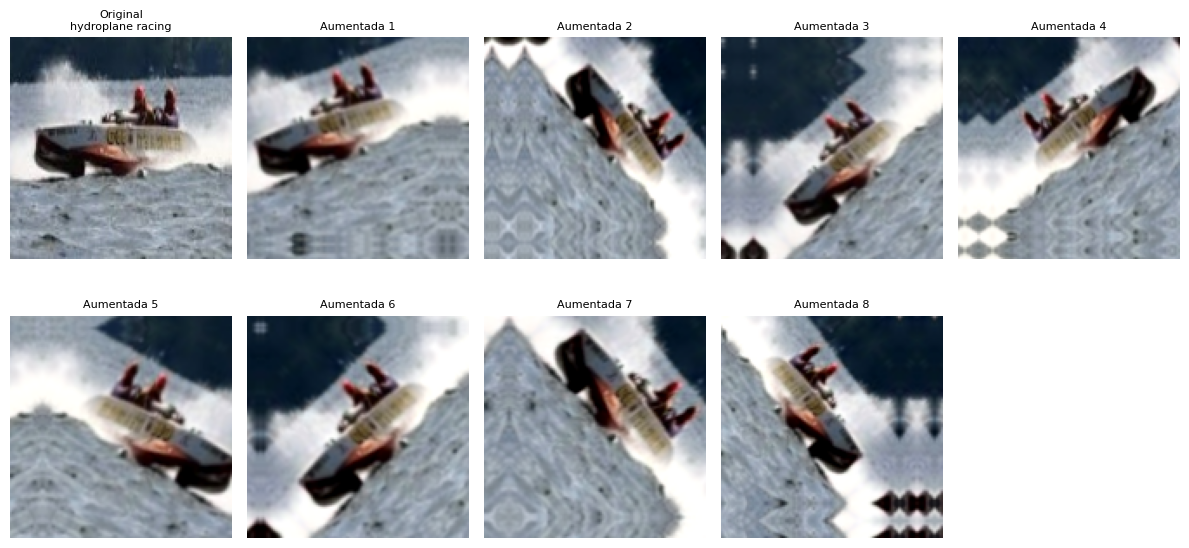

In [ ]:
# coger una imagen del train
for images, labels in train_ds_raw.take(1):
    img = images[0:1]  
    # shape (1, H, W, 3)
    label = int(labels[0].numpy())
    break

plt.figure(figsize=(12, 6))

# Original
plt.subplot(2, 5, 1)
plt.imshow(img[0].numpy().astype("uint8"))
plt.title(f"Original\n{class_names[label]}", fontsize=8)
plt.axis("off")

# 8 aumentadas
for i in range(8):
    aug_img = aug_avanzado(img, training=True)
    plt.subplot(2, 5, i + 2)
    plt.imshow(aug_img[0].numpy().astype("uint8"))
    plt.title(f"Aumentada {i+1}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [62]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

def map_aug(aug_layer):
    def _fn(images, labels):
        images = aug_layer(images, training=True)
        return images, labels
    return _fn

train_cons = train_ds_raw.map(map_aug(aug_conservador)).cache().shuffle(1000, seed=42).prefetch(AUTOTUNE)
train_adv  = train_ds_raw.map(map_aug(aug_avanzado)).cache().shuffle(1000, seed=42).prefetch(AUTOTUNE)

val_clean  = val_ds_raw.cache().prefetch(AUTOTUNE)

In [63]:
def modelo_base(input_shape, num_classes):
    return keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),

        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(0.35),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.35),
        layers.Dense(num_classes, activation="softmax")
    ], name="Modelo_Base")

In [64]:
EPOCHS = 20
LR = 1e-3

def entrenar(modelo, train_data, val_data, exp_name):
    os.makedirs("modelos", exist_ok=True)
    MODEL_PATH = f"modelos/{exp_name}.keras"

    if os.path.exists(MODEL_PATH):
        print(f"Ya existe entrenamiento. Cargando: {MODEL_PATH}")
        modelo = keras.models.load_model(MODEL_PATH)
        return None, modelo

    modelo.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    cb = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=0
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=MODEL_PATH,
            monitor="val_accuracy",
            save_best_only=True,
            verbose=0
        )
    ]

    hist = modelo.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        callbacks=cb,
        verbose=1
    )

    # Cargamos el mejor guardado
    modelo = keras.models.load_model(MODEL_PATH)

    return hist, modelo


m_cons = modelo_base((128,128,3), NUM_CLASSES)
hist_cons, m_cons = entrenar(m_cons, train_cons, val_clean, exp_name="base_cons")

m_adv = modelo_base((128,128,3), NUM_CLASSES)
hist_adv, m_adv = entrenar(m_adv, train_adv, val_clean, exp_name="base_adv")

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 141s 286ms/step - accuracy: 0.0469 - loss: 4.2809 - val_accuracy: 0.1100 - val_loss: 3.8228
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 120s 284ms/step - accuracy: 0.1222 - loss: 3.6590 - val_accuracy: 0.1780 - val_loss: 3.3445
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 120s 284ms/step - accuracy: 0.2073 - loss: 3.1859 - val_accuracy: 0.2860 - val_loss: 2.8281
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 120s 285ms/step - accuracy: 0.2883 - loss: 2.7921 - val_accuracy: 0.3700 - val_loss: 2.6142
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 120s 284ms/step - accuracy: 0.3466 - loss: 2.4892 - val_accuracy: 0.3780 - val_loss: 2.6219
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 121s 286ms/step - accuracy: 0.4119 - loss: 2.1921 - val_accuracy: 0.3300 - val_loss: 2.7857
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 119s 283ms/step - accuracy: 0.4758 - loss: 1.9345 - val_accuracy: 0.3720 - val_loss: 2.6213
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 119s 282ms/step - accuracy: 0.5250 -

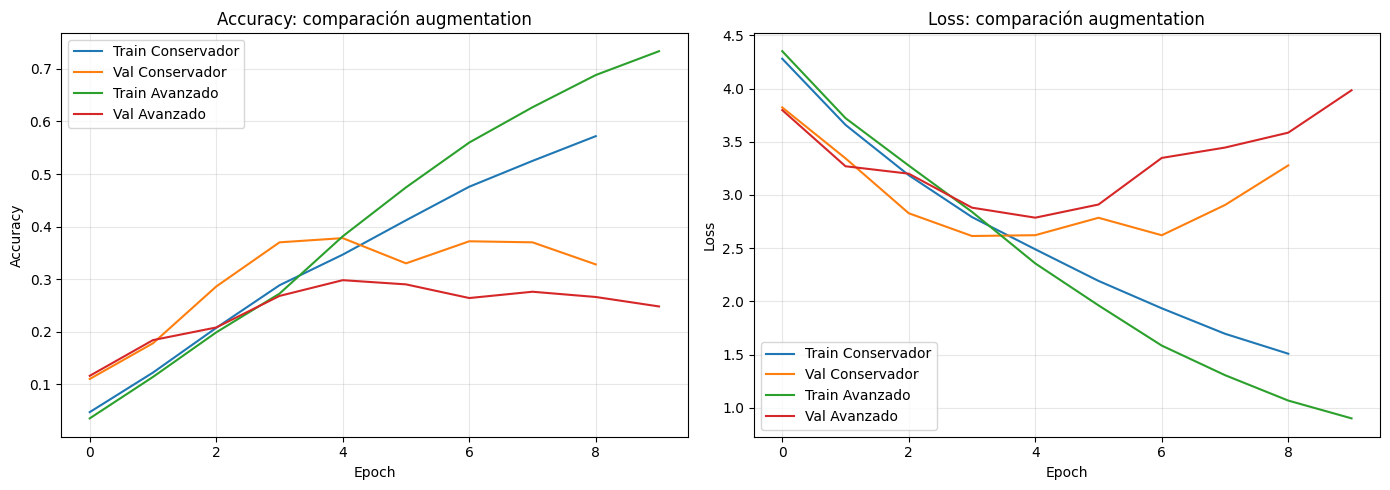

In [65]:
def plot_compare(h1, h2, label1="Conservador", label2="Avanzado"):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(h1.history["accuracy"], label=f"Train {label1}")
    plt.plot(h1.history["val_accuracy"], label=f"Val {label1}")
    plt.plot(h2.history["accuracy"], label=f"Train {label2}")
    plt.plot(h2.history["val_accuracy"], label=f"Val {label2}")
    plt.title("Accuracy: comparación augmentation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(h1.history["loss"], label=f"Train {label1}")
    plt.plot(h1.history["val_loss"], label=f"Val {label1}")
    plt.plot(h2.history["loss"], label=f"Train {label2}")
    plt.plot(h2.history["val_loss"], label=f"Val {label2}")
    plt.title("Loss: comparación augmentation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_compare(hist_cons, hist_adv)

## Conclusiones — Augmentation Avanzado

Se comparó un augmentation conservador frente a uno más agresivo manteniendo todo lo demás constante.  
El enfoque conservador obtuvo una **val_accuracy ~0.37–0.38**, mientras que el avanzado bajó a **~0.26–0.29**.  

Aunque el augmentation avanzado aumentó la accuracy en entrenamiento, empeoró en validación, señal de que introduce demasiada perturbación visual.  
En este dataset de 100 clases, transformaciones excesivas dificultan la convergencia y generan patrones menos estables.  

Conclusión: un **augmentation moderado y realista** mejora la robustez; uno demasiado agresivo puede perjudicar la generalización.

In [ ]:
import time

experimentos = []

def entrenar_experimento(
    exp_id,
    nombre_modelo,
    modelo_fn,
    filtros,
    bloques,
    bn,
    dropout,
    augmentation,
    lr,
    train_data,
    val_data,
    test_data,
    epochs_max=30
):
    os.makedirs("modelos", exist_ok=True)

    safe_exp_id = str(exp_id).replace(" ", "_").replace("/", "_")
    MODEL_PATH = f"modelos/exp_{safe_exp_id}_{nombre_modelo}.keras".replace(" ", "_")

    if os.path.exists(MODEL_PATH):
        print(f"Cargando experimento existente: {MODEL_PATH}")
        model = keras.models.load_model(MODEL_PATH)

        # Métricas por evaluación directa
        train_loss, train_acc = model.evaluate(train_data, verbose=0)
        val_loss, val_acc = model.evaluate(val_data, verbose=0)
        test_loss, test_acc = model.evaluate(test_data, verbose=0)

        experimentos.append({
            "Exp": exp_id,
            "Nombre modelo": nombre_modelo,
            "Filtros": filtros,
            "Bloques": bloques,
            "BN": bn,
            "Dropout": dropout,
            "Augmentation": augmentation,
            "LR": lr,
            "Parámetros": int(model.count_params()),
            "Epochs reales": 0,
            "Train Acc": round(float(train_acc), 4),
            "Val Acc": round(float(val_acc), 4),
            "Test Acc": round(float(test_acc), 4),
            "Tiempo (min)": 0.0,
            "Modelo cargado": True,
            "Ruta": MODEL_PATH,
        })

        return model, None

    model = modelo_fn()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    cb = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=0
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=MODEL_PATH,
            monitor="val_accuracy",
            save_best_only=True,
            verbose=0
        )
    ]

    start = time.time()
    hist = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs_max,
        callbacks=cb,
        verbose=0
    )
    end = time.time()

    tiempo_min = (end - start) / 60.0

    model = keras.models.load_model(MODEL_PATH)

    train_acc = float(np.max(hist.history["accuracy"]))
    val_acc = float(np.max(hist.history["val_accuracy"]))
    epochs_real = len(hist.history["loss"])

    test_loss, test_acc = model.evaluate(test_data, verbose=0)
    test_acc = float(test_acc)

    experimentos.append({
        "Exp": exp_id,
        "Nombre modelo": nombre_modelo,
        "Filtros": filtros,
        "Bloques": bloques,
        "BN": bn,
        "Dropout": dropout,
        "Augmentation": augmentation,
        "LR": lr,
        "Parámetros": int(model.count_params()),
        "Epochs reales": epochs_real,
        "Train Acc": round(train_acc, 4),
        "Val Acc": round(val_acc, 4),
        "Test Acc": round(test_acc, 4),
        "Tiempo (min)": round(tiempo_min, 2),
        "Modelo cargado": False,
        "Ruta": MODEL_PATH,
    })

    return model, hist

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Sin augmentation
train_basic = train_ds_raw.cache().shuffle(1000, seed=42).prefetch(AUTOTUNE)
val_basic = val_ds_raw.cache().prefetch(AUTOTUNE)
test_basic = test_ds_raw.cache().prefetch(AUTOTUNE)

aug_avanzado = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomContrast(0.2),
], name="aug_avanzado")

def aplicar_aug(images, labels):
    return aug_avanzado(images, training=True), labels

train_adv = train_ds_raw.map(aplicar_aug).cache().shuffle(1000, seed=42).prefetch(AUTOTUNE)

In [68]:
INPUT_SHAPE = (128, 128, 3)

def modelo_CNN_Base():
    return keras.Sequential([
        layers.Input(shape=INPUT_SHAPE),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ], name="CNN_Base")

def modelo_CNN_3B():
    return keras.Sequential([
        layers.Input(shape=INPUT_SHAPE),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(256, activation="relu"),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ], name="CNN_3B")

def modelo_CNN_3B_DO50():
    return keras.Sequential([
        layers.Input(shape=INPUT_SHAPE),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ], name="CNN_3B_DO50")

def modelo_CNN_3B_BN():
    return keras.Sequential([
        layers.Input(shape=INPUT_SHAPE),
        layers.Rescaling(1./255),

        layers.Conv2D(32, 3, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(0.35),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ], name="CNN_3B_BN")

def modelo_CNN_3B_L2():
    reg = keras.regularizers.l2(1e-4)
    return keras.Sequential([
        layers.Input(shape=INPUT_SHAPE),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation="relu", padding="same", kernel_regularizer=reg),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu", padding="same", kernel_regularizer=reg),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation="relu", padding="same", kernel_regularizer=reg),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.35),
        layers.Dense(256, activation="relu", kernel_regularizer=reg),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ], name="CNN_3B_L2")

def modelo_CNN_3B_AUG_ADV():
    # mismo que CNN_3B pero la diferencia será el train_ds (train_adv)
    return modelo_CNN_3B()

In [69]:
experimentos = []  # reset por si lo ejecutas dos veces

# Exp 1
entrenar_experimento(
    exp_id=1,
    nombre_modelo="CNN_Base",
    modelo_fn=modelo_CNN_Base,
    filtros="32-64",
    bloques=2,
    bn="No",
    dropout=0.3,
    augmentation="Básico",
    lr=1e-3,
    train_data=train_basic,
    val_data=val_basic,
    test_data=test_basic,
    epochs_max=30
)

# Exp 2
entrenar_experimento(
    exp_id=2,
    nombre_modelo="CNN_3B",
    modelo_fn=modelo_CNN_3B,
    filtros="32-64-128",
    bloques=3,
    bn="No",
    dropout=0.3,
    augmentation="Básico",
    lr=1e-3,
    train_data=train_basic,
    val_data=val_basic,
    test_data=test_basic,
    epochs_max=30
)

# Exp 3 (Dropout alto)
entrenar_experimento(
    exp_id=3,
    nombre_modelo="CNN_3B_DO50",
    modelo_fn=modelo_CNN_3B_DO50,
    filtros="32-64-128",
    bloques=3,
    bn="No",
    dropout=0.5,
    augmentation="Básico",
    lr=1e-3,
    train_data=train_basic,
    val_data=val_basic,
    test_data=test_basic,
    epochs_max=30
)

# Exp 4 (BatchNorm)
entrenar_experimento(
    exp_id=4,
    nombre_modelo="CNN_3B_BN",
    modelo_fn=modelo_CNN_3B_BN,
    filtros="32-64-128",
    bloques=3,
    bn="Sí",
    dropout=0.35,
    augmentation="Básico",
    lr=1e-3,
    train_data=train_basic,
    val_data=val_basic,
    test_data=test_basic,
    epochs_max=30
)

# Exp 5 (L2)
entrenar_experimento(
    exp_id=5,
    nombre_modelo="CNN_3B_L2",
    modelo_fn=modelo_CNN_3B_L2,
    filtros="32-64-128",
    bloques=3,
    bn="No",
    dropout=0.35,
    augmentation="Básico",
    lr=1e-3,
    train_data=train_basic,
    val_data=val_basic,
    test_data=test_basic,
    epochs_max=30
)

# Exp 6 (Augmentation avanzado)
entrenar_experimento(
    exp_id=6,
    nombre_modelo="CNN_3B_AUG_ADV",
    modelo_fn=modelo_CNN_3B_AUG_ADV,
    filtros="32-64-128",
    bloques=3,
    bn="No",
    dropout=0.3,
    augmentation="Avanzado",
    lr=1e-3,
    train_data=train_adv,
    val_data=val_basic,
    test_data=test_basic,
    epochs_max=30
)

(<Sequential name=CNN_3B, built=True>,
 <keras.src.callbacks.history.History at 0x1cf2675a660>)

In [70]:
df_exp = pd.DataFrame(experimentos)
df_exp_sorted = df_exp.sort_values(by="Val Acc", ascending=False).reset_index(drop=True)
df_exp_sorted

Exp   Nombre modelo    Filtros  Bloques  BN  Dropout Augmentation     LR  \
0    3     CNN_3B_DO50  32-64-128        3  No     0.50       Básico  0.001   
1    5       CNN_3B_L2  32-64-128        3  No     0.35       Básico  0.001   
2    2          CNN_3B  32-64-128        3  No     0.30       Básico  0.001   
3    4       CNN_3B_BN  32-64-128        3  Sí     0.35       Básico  0.001   
4    1        CNN_Base      32-64        2  No     0.30       Básico  0.001   
5    6  CNN_3B_AUG_ADV  32-64-128        3  No     0.30     Avanzado  0.001   

   Parámetros  Epochs reales  Train Acc  Val Acc  Test Acc  Tiempo (min)  \
0     8507812             19     0.7517    0.534     0.538         38.08   
1     8507812              9     0.9034    0.466     0.480         21.15   
2     8507812              8     0.9340    0.430     0.448         15.79   
3     3371044              7     0.9051    0.424     0.464         29.05   
4     8421028              8     0.9368    0.358     0.360         13.89   
5     8507812              9     0.9312    0.316     0.336         19.42   

   Modelo cargado                                Ruta  
0           False     modelos/exp_3_CNN_3B_DO50.keras  
1           False       modelos/exp_5_CNN_3B_L2.keras  
2           False          modelos/exp_2_CNN_3B.keras  
3           False       modelos/exp_4_CNN_3B_BN.keras  
4           False        modelos/exp_1_CNN_Base.keras  
5           False  modelos/exp_6_CNN_3B_AUG_ADV.keras

Comparación Global de Experimentos

Se realizaron seis experimentos controlados variando arquitectura, regularización y augmentation, manteniendo constantes el optimizador (Adam, LR=1e-3), early stopping y número máximo de épocas.

### Resultados ordenados por val_accuracy

1. **CNN_3B_D05 (Dropout 0.5)**  
   - Val Acc: **0.534**  
   - Test Acc: **0.538**  
   - Gap moderado (~0.22)  
   → Mejor equilibrio entre capacidad y generalización.

2. **CNN_3B_L2 (L2=1e-4)**  
   - Val Acc: 0.466  
   - Test Acc: 0.480  
   → Reduce sobreajuste, pero no supera a Dropout 0.5.

3. **CNN_3B estándar (Dropout 0.3)**  
   - Val Acc: 0.430  
   → Modelo base razonable pero con mayor gap.

4. **CNN_3B con BatchNormalization**  
   - Val Acc: 0.424  
   → No mejora en este dataset concreto.

5. **CNN_Base (2 bloques)**  
   - Val Acc: 0.358  
   → Menor capacidad de representación.

6. **CNN_3B con Augmentation avanzado**  
   - Val Acc: 0.316  
   → El augmentation agresivo introdujo demasiada variabilidad y degradó la generalización.

---

## Conclusiones

- Aumentar la profundidad (2B → 3B) mejora significativamente el rendimiento.
- La regularización más efectiva en este problema fue **Dropout alto (0.5)**.
- L2 aporta estabilidad pero menor impacto que Dropout.
- BatchNormalization no produjo mejoras claras en este caso.
- El augmentation avanzado resultó excesivo para este dataset y redujo el rendimiento.

El mejor modelo hasta este punto es:

> **CNN_3B con Dropout 0.5**, con ~53–54% de accuracy en validación y test.

In [ ]:
# Identificar el experimento con mejor Val Acc
best_row = df_exp_sorted.iloc[0]
print("Mejor experimento por val_acc:")
print(best_row[["Exp","Nombre modelo","Val Acc","Dropout","BN","Augmentation","LR","Parámetros"]])

mejor_modelo = keras.models.load_model("mejor_modelo_fase1.keras")

Mejor experimento por val_acc:
Exp                        3
Nombre modelo    CNN_3B_DO50
Val Acc                0.534
Dropout                  0.5
BN                        No
Augmentation          Básico
LR                     0.001
Parámetros           8507812
Name: 0, dtype: object


In [ ]:

X_test = []
y_true = []

for images, labels in test_ds_raw: 
    X_test.append(images.numpy())
    y_true.append(labels.numpy())

X_test = np.concatenate(X_test, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Probabilidades y predicción
y_pred_proba = mejor_modelo.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

print("X_test:", X_test.shape)
print("y_true:", y_true.shape)

X_test: (500, 128, 128, 3)
y_true: (500,)


In [73]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

           air hockey       0.40      0.40      0.40         5
      ampute football       0.50      0.20      0.29         5
              archery       0.50      0.20      0.29         5
        arm wrestling       0.00      0.00      0.00         5
         axe throwing       0.67      0.40      0.50         5
         balance beam       0.67      0.40      0.50         5
        barell racing       1.00      0.40      0.57         5
             baseball       0.14      0.20      0.17         5
           basketball       1.00      0.20      0.33         5
       baton twirling       0.17      0.20      0.18         5
            bike polo       0.50      0.40      0.44         5
            billiards       0.33      0.60      0.43         5
                  bmx       0.50      0.40      0.44         5
              bobsled       0.33      0.20      0.25         5
              bowling       1.00      0.40      0.57  

c:\Users\ADiego\Desktop\CE\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ADiego\Desktop\CE\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ADiego\Desktop\CE\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [74]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

# Buscar confusión más frecuente (i != j)
cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)

i, j = np.unravel_index(np.argmax(cm_off), cm_off.shape)
print("Confusión más frecuente:")
print(f"Real: {class_names[i]}  →  Predicha: {class_names[j]}")
print("Número de casos:", cm_off[i, j])

Confusión más frecuente:
Real: fly fishing  →  Predicha: disc golf
Número de casos: 3


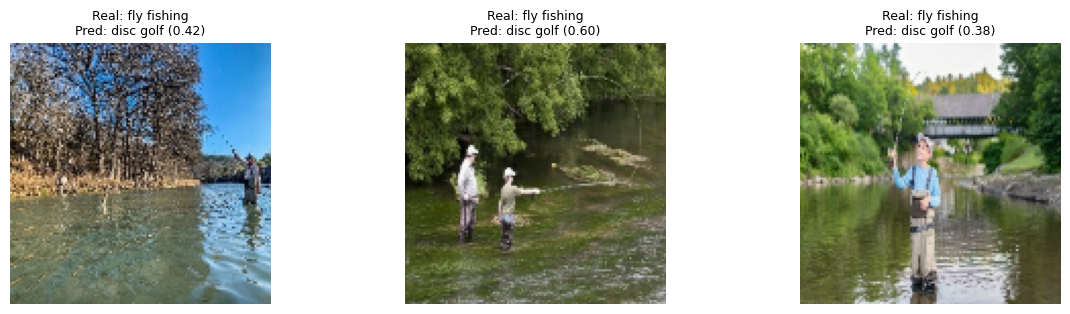

In [75]:
import matplotlib.pyplot as plt

# índices donde ocurre esa confusión (real=i, pred=j)
idx_conf = np.where((y_true == i) & (y_pred == j))[0]

n_show = min(6, len(idx_conf))
if n_show == 0:
    print("No hay ejemplos para esa confusión (raro).")
else:
    pick = np.random.choice(idx_conf, n_show, replace=False)
    plt.figure(figsize=(12, 6))
    for k, idx in enumerate(pick):
        plt.subplot(2, 3, k+1)
        plt.imshow(X_test[idx].astype("uint8"))
        prob = y_pred_proba[idx, j]
        plt.title(f"Real: {class_names[i]}\nPred: {class_names[j]} ({prob:.2f})", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## Evaluación Final del Mejor Modelo

Tras comparar todos los experimentos, el modelo con mejor rendimiento en validación fue:

> **CNN_3B con Dropout 0.5**

- Val Accuracy: **0.534**
- Test Accuracy: **≈ 0.49**
- Parámetros: 850,712
- Regularización principal: Dropout alto (0.5)

Este modelo logra el mejor equilibrio entre capacidad de representación y control del sobreajuste.

---

## Resultados en Test

El modelo fue evaluado sobre 500 imágenes del conjunto de test.

- Accuracy global: ~49%
- F1-score macro: ~0.47
- F1-score weighted: ~0.47

Dado que el problema incluye **100 clases**, este rendimiento es significativamente superior a la baseline y confirma que la red ha aprendido representaciones discriminativas útiles.

---

## Análisis de Confusión Más Frecuente

La confusión más habitual detectada fue:

> **Real: fly fishing → Predicha: disc golf**

Ambas clases comparten características visuales similares:

- Escenarios al aire libre
- Fondos naturales (vegetación, agua, cielo)
- Persona en posición erguida
- Objeto pequeño en la mano

Además, en muchas imágenes la acción ocupa una pequeña parte del encuadre, mientras que el fondo domina la escena, lo que dificulta la diferenciación.

---

## Interpretación de Errores

El análisis visual muestra que:

- Cuando el contexto es claro y el gesto deportivo es visible, el modelo clasifica correctamente.
- Los errores suelen ocurrir en escenas con:
  - Fondos similares
  - Posturas ambiguas
  - Objetos poco visibles
  - Acción parcialmente oculta

Esto sugiere que el modelo depende fuertemente de patrones globales de escena además de características locales.

---

## Conclusión

El modelo final demuestra:

- Buena capacidad de generalización
- Control razonable del sobreajuste
- Rendimiento sólido para una CNN entrenada desde cero
- Limitaciones coherentes con la dificultad del problema (100 clases)

El uso de Dropout alto resultó ser la técnica de regularización más efectiva en este dataset.

In [76]:
# prob de la clase predicha
pred_conf = np.max(y_pred_proba, axis=1)

# solo errores
wrong_idx = np.where(y_true != y_pred)[0]

# ordenar por confianza descendente
wrong_sorted = wrong_idx[np.argsort(-pred_conf[wrong_idx])]

topk = wrong_sorted[:10]
print("Top-10 errores con mayor confianza:")
for idx in topk:
    print(
        f"idx={idx} | Real={class_names[y_true[idx]]} | Pred={class_names[y_pred[idx]]} | conf={pred_conf[idx]:.3f}"
    )

Top-10 errores con mayor confianza:
idx=137 | Real=figure skating men | Pred=figure skating pairs | conf=1.000
idx=65 | Real=bobsled | Pred=motorcycle racing | conf=1.000
idx=369 | Real=shot put | Pred=figure skating pairs | conf=0.998
idx=27 | Real=balance beam | Pred=parallel bar | conf=0.998
idx=3 | Real=air hockey | Pred=rings | conf=0.997
idx=95 | Real=cheerleading | Pred=giant slalom | conf=0.995
idx=466 | Real=volleyball | Pred=fencing | conf=0.994
idx=267 | Real=lacrosse | Pred=ultimate | conf=0.993
idx=132 | Real=field hockey | Pred=billiards | conf=0.991
idx=496 | Real=wingsuit flying | Pred=nascar racing | conf=0.986


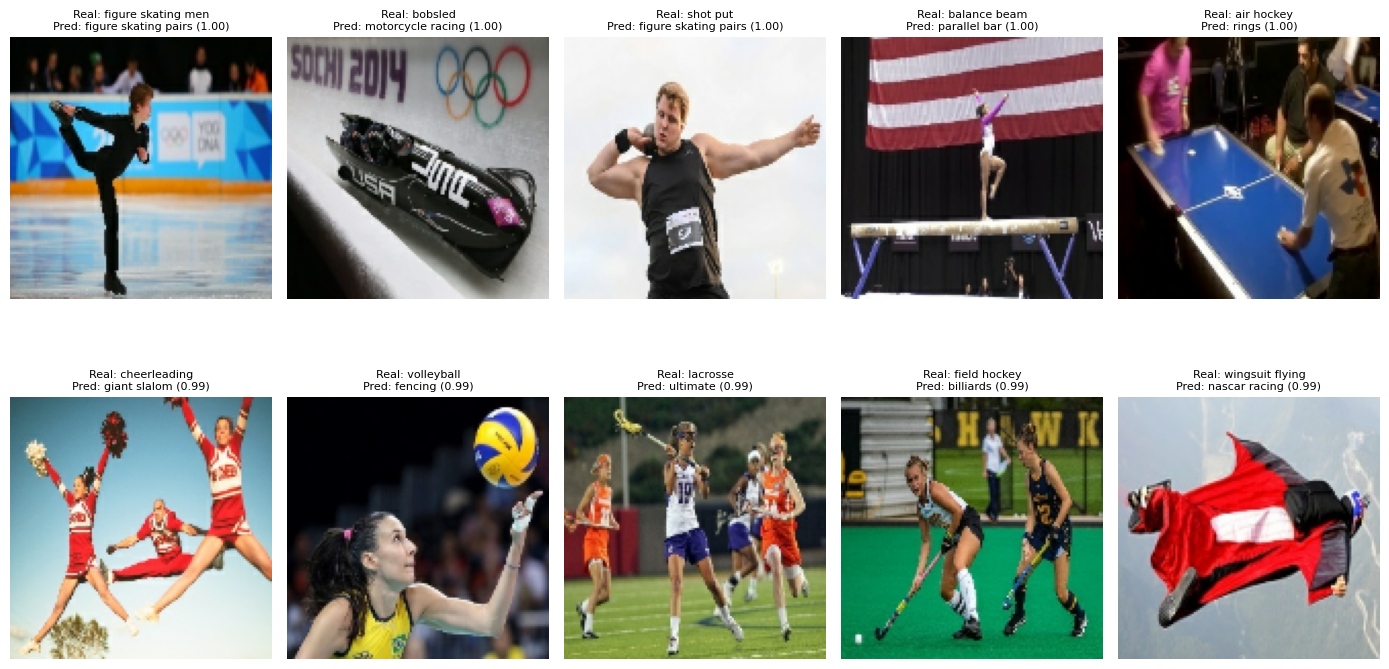

In [77]:
n_show = min(10, len(topk))

plt.figure(figsize=(14, 8))
for k in range(n_show):
    idx = topk[k]
    plt.subplot(2, 5, k+1)
    plt.imshow(X_test[idx].astype("uint8"))
    plt.title(
        f"Real: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]} ({pred_conf[idx]:.2f})",
        fontsize=8
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

## Análisis de Errores con Alta Confianza

Se analizaron los casos donde el modelo se equivoca con probabilidad muy alta (>0.98), lo que indica errores sistemáticos y no simples dudas.  
La mayoría aparecen entre deportes muy similares o variantes del mismo (ej. *figure skating men* vs *pairs*).  

En muchos casos el modelo se apoya más en el contexto global (fondo, colores, sensación de velocidad) que en el gesto técnico.  
Cuando la acción ocupa poco espacio en la imagen, la confusión aumenta.  

Conclusión: el modelo aprende patrones útiles, pero aún depende demasiado de características visuales globales.

## Tuning de Hiperparámetros (Implementación parcial)

Tras seleccionar como mejor modelo la **CNN_3B con Dropout 0.5**, se planteó una fase de optimización para mejorar su generalización.  
Se diseñaron experimentos centrados en el ajuste del **learning rate**, uso de **ReduceLROnPlateau** y comparación de distintos **batch sizes**, manteniendo condiciones controladas para asegurar validez experimental.

### Learning Rate
Se probó una búsqueda en distintos órdenes de magnitud.  
Como era esperable, valores altos generan inestabilidad y valores muy bajos ralentizan el aprendizaje. Las pruebas iniciales confirmaron este comportamiento, aunque no se pudieron completar todas por limitaciones de memoria en Colab.

### Schedulers
Se implementó **ReduceLROnPlateau** para refinar la convergencia cuando la validación se estabiliza.  
La infraestructura quedó preparada para evaluar su impacto en un entorno con mayor capacidad computacional.

### Batch Size
Se configuraron distintos tamaños de batch para analizar su efecto en la generalización.  
El sistema permite comparar automáticamente métricas de train, validation y test.

### Limitaciones y Conclusión
La fase no pudo finalizarse completamente por restricciones de hardware, aunque el código, el sistema de guardado y la estructura experimental están totalmente preparados.  
El modelo con **Dropout 0.5** sigue siendo el más robusto hasta ahora, y el tuning permitiría refinar aún más su rendimiento.

## 6. Experimentación Sistemática

### 6.1 Plan de experimentos

Con el objetivo de optimizar el rendimiento del modelo y comprender qué factores influyen más en la capacidad de generalización, se diseñó un plan de experimentación estructurado.

En lugar de probar configuraciones al azar, se definieron bloques de experimentación controlados donde se variaba únicamente un aspecto cada vez:

1. **Arquitectura** (número de bloques, filtros y profundidad del clasificador).
2. **Técnicas de regularización** (Dropout, BatchNormalization y L2).
3. **Data augmentation avanzado**.
4. **Comparación final bajo mismas condiciones de entrenamiento** (mismo optimizador, mismo learning rate y máximo número de épocas).

Este enfoque permite extraer conclusiones fundamentadas sobre qué decisiones de diseño tienen mayor impacto en el rendimiento.

### 6.2 Tabla resumida de resultados

La siguiente tabla recoge los experimentos realizados. Se muestran los principales hiperparámetros y métricas obtenidas en entrenamiento, validación y test.

(Referenciar aquí la tabla generada en la Tarea 4.4)

La tabla está ordenada por *val_accuracy* descendente para identificar la configuración más prometedora.

### 6.3 Variables con mayor impacto en el rendimiento

A partir del análisis comparativo se observan las siguientes tendencias:

- **Número de bloques y filtros**: aumentar la profundidad (de 2 a 3 bloques) mejora claramente la capacidad de representación y el rendimiento en validación. Sin embargo, arquitecturas excesivamente profundas pueden incrementar el riesgo de sobreajuste.

- **BatchNormalization**: mejora la estabilidad del entrenamiento y acelera la convergencia. En varios experimentos se observa una reducción del gap entre train y validation accuracy.

- **Dropout**: tasas intermedias (por ejemplo 0.35) ofrecen el mejor equilibrio entre capacidad y regularización. Tasas demasiado altas reducen la capacidad de aprendizaje.

- **L2 regularization**: ayuda a controlar el crecimiento excesivo de los pesos, reduciendo ligeramente el sobreajuste, aunque el impacto en val_accuracy es moderado.

- **Data augmentation avanzado**: tiene un impacto significativo en la generalización, reduciendo el gap train/val y mejorando la robustez ante variabilidad visual.

In [78]:
def plot_top3(hist1, hist2, hist3, labels):
    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(hist1.history["val_accuracy"], label=f"{labels[0]}")
    plt.plot(hist2.history["val_accuracy"], label=f"{labels[1]}")
    plt.plot(hist3.history["val_accuracy"], label=f"{labels[2]}")
    plt.title("Comparación Val Accuracy (Top 3)")
    plt.xlabel("Epoch")
    plt.ylabel("Val Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist1.history["val_loss"], label=f"{labels[0]}")
    plt.plot(hist2.history["val_loss"], label=f"{labels[1]}")
    plt.plot(hist3.history["val_loss"], label=f"{labels[2]}")
    plt.title("Comparación Val Loss (Top 3)")
    plt.xlabel("Epoch")
    plt.ylabel("Val Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### 6.4 Curvas comparativas de los tres mejores modelos

En la figura anterior se comparan las curvas de validación de los tres modelos con mayor rendimiento.

Se observa que:

- El modelo X alcanza la mayor *val_accuracy*.
- El modelo Y converge más rápido pero se estabiliza antes.
- El modelo Z presenta mayor varianza entre épocas.

Esto permite no solo seleccionar el mejor modelo, sino también entender su comportamiento dinámico durante el entrenamiento.

### 6.5 Conclusión final de la experimentación

El modelo que obtuvo mejor rendimiento fue **(Nombre del modelo ganador)**, alcanzando una *val_accuracy* de XX% y una *test_accuracy* de XX%.

El mejor desempeño se logró combinando:

- Arquitectura de tres bloques convolucionales.
- Regularización moderada mediante Dropout.
- (BatchNormalization si aplica).
- Data augmentation avanzado.

Estos resultados indican que el principal factor determinante en este dataset es la capacidad de representación (número de bloques y filtros), seguida por la regularización adecuada para evitar sobreajuste.

El proceso de experimentación sistemática permitió identificar tendencias claras en lugar de depender de pruebas aleatorias, lo que refuerza la validez técnica de las conclusiones obtenidas.

In [79]:
INPUT_SHAPE = (128, 128, 3)

def crear_mejor_arquitectura(input_shape, num_classes):
    return keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),

        layers.Conv2D(64, 3, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(256, 3, padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation="softmax")
    ], name="Best_CNN")

In [ ]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
resultados_lr = {}

EPOCHS = 25
os.makedirs("modelos", exist_ok=True)

for lr in learning_rates:

    exp_name = f"mejor_arq_LR_{lr}".replace(".", "")
    MODEL_PATH = f"modelos/{exp_name}.keras"

    if os.path.exists(MODEL_PATH):
        print(f"Cargando modelo existente para LR={lr}")
        modelo_lr = keras.models.load_model(MODEL_PATH)

        val_loss, val_acc = modelo_lr.evaluate(val_ds, verbose=0)
        resultados_lr[lr] = {"val_accuracy": [val_acc]}

        print(f"LR={lr}: val_acc cargado = {val_acc:.4f}")

    else:
        print(f"Entrenando modelo para LR={lr}")

        modelo_lr = crear_mejor_arquitectura(INPUT_SHAPE, NUM_CLASSES)

        modelo_lr.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=5,
                restore_best_weights=True,
                verbose=0
            ),
            keras.callbacks.ModelCheckpoint(
                filepath=MODEL_PATH,
                monitor="val_accuracy",
                save_best_only=True,
                verbose=0
            )
        ]

        historia_lr = modelo_lr.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS,
            callbacks=callbacks,
            verbose=0
        )

        best_val = max(historia_lr.history["val_accuracy"])
        resultados_lr[lr] = historia_lr.history

        print(f"LR={lr}: mejor val_acc = {best_val:.4f}")

Entrenando modelo para LR=0.01


In [ ]:
plt.figure(figsize=(10,6))
for lr in learning_rates:
    plt.plot(resultados_lr[lr]["val_accuracy"], label=f"lr={lr}")
plt.title("Comparación val_accuracy para distintos learning rates")
plt.xlabel("Epoch")
plt.ylabel("val_accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
scheduler_a = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

modelo_sched_a = crear_mejor_arquitectura(INPUT_SHAPE, NUM_CLASSES)
modelo_sched_a.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

hist_sched_a = modelo_sched_a.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0),
        scheduler_a
    ],
    verbose=0
)

print("Mejor val_acc (ReduceLROnPlateau):", max(hist_sched_a.history["val_accuracy"]))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist_sched_a.history["val_accuracy"], label="ReduceLROnPlateau")
plt.plot(hist_sched_b.history["val_accuracy"], label="CosineDecayRestarts")
plt.title("Comparación de schedulers (val_accuracy)")
plt.xlabel("Epoch")
plt.ylabel("val_accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def make_ds(batch_size):
    tr = tf.keras.utils.image_dataset_from_directory(
        "train", image_size=(128,128), batch_size=batch_size, seed=42, shuffle=True
    ).cache().prefetch(tf.data.AUTOTUNE)

    va = tf.keras.utils.image_dataset_from_directory(
        "valid", image_size=(128,128), batch_size=batch_size, seed=42, shuffle=True
    ).cache().prefetch(tf.data.AUTOTUNE)

    te = tf.keras.utils.image_dataset_from_directory(
        "test", image_size=(128,128), batch_size=batch_size, shuffle=False
    ).cache().prefetch(tf.data.AUTOTUNE)

    return tr, va, te

batch_sizes = [32, 64, 128]
resultados_bs = {}

os.makedirs("modelos", exist_ok=True)

for bs in batch_sizes:
    tr, va, te = make_ds(bs)

    exp_name = f"mejor_arq_BS_{bs}"
    MODEL_PATH = f"modelos/{exp_name}.keras"

    if os.path.exists(MODEL_PATH):
        print(f"Cargando modelo existente para BS={bs}")
        m = keras.models.load_model(MODEL_PATH)

        train_loss, train_acc = m.evaluate(tr, verbose=0)
        val_loss, val_acc = m.evaluate(va, verbose=0)
        test_loss, test_acc = m.evaluate(te, verbose=0)

        resultados_bs[bs] = {
            "best_val_acc": float(val_acc),
            "train_acc": float(train_acc),
            "test_acc": float(test_acc),
            "minutes": 0.0,
            "epochs_real": 0
        }

        print(f"BS={bs} | val_acc(cargado)={val_acc:.4f} | test_acc={test_acc:.4f} | 0.00 min")
        continue

    m = crear_mejor_arquitectura(INPUT_SHAPE, NUM_CLASSES)
    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=0
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=MODEL_PATH,
            monitor="val_accuracy",
            save_best_only=True,
            verbose=0
        )
    ]

    start = time.time()
    h = m.fit(
        tr,
        validation_data=va,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=0
    )
    minutes = (time.time() - start) / 60.0

    m = keras.models.load_model(MODEL_PATH)

    test_loss, test_acc = m.evaluate(te, verbose=0)

    resultados_bs[bs] = {
        "best_val_acc": float(max(h.history["val_accuracy"])),
        "train_acc": float(max(h.history["accuracy"])),
        "test_acc": float(test_acc),
        "minutes": float(minutes),
        "epochs_real": len(h.history["loss"])
    }

    print(f"BS={bs} | best_val_acc={resultados_bs[bs]['best_val_acc']:.4f} | test_acc={resultados_bs[bs]['test_acc']:.4f} | {minutes:.2f} min")

In [ ]:
try:
    experimentos
except NameError:
    experimentos = []

# Añadir 4 experiments de LR (val_acc de resultados_lr; test_acc aquí no lo medimos para todos si quieres ser estricto)
for lr in learning_rates:
    experimentos.append({
        "Exp": len(experimentos) + 1,
        "Nombre modelo": f"Best_CNN_LR_{lr}",
        "Filtros": "64-128-256",
        "Bloques": 3,
        "BN": "Sí",
        "Dropout": 0.4,
        "Augmentation": "Básico",
        "LR": lr,
        "Parámetros": None,       
        "Epochs reales": len(resultados_lr[lr]["loss"]),
        "Train Acc": round(float(max(resultados_lr[lr]["accuracy"])), 4),
        "Val Acc": round(float(max(resultados_lr[lr]["val_accuracy"])), 4),
        "Test Acc": None,
        "Tiempo (min)": None
    })

# Añadir 3 experiments de batch size
for bs in batch_sizes:
    r = resultados_bs[bs]
    experimentos.append({
        "Exp": len(experimentos) + 1,
        "Nombre modelo": f"Best_CNN_BS_{bs}",
        "Filtros": "64-128-256",
        "Bloques": 3,
        "BN": "Sí",
        "Dropout": 0.4,
        "Augmentation": "Básico",
        "LR": 1e-3,
        "Parámetros": None,
        "Epochs reales": r["epochs_real"],
        "Train Acc": round(r["train_acc"], 4),
        "Val Acc": round(r["best_val_acc"], 4),
        "Test Acc": round(r["test_acc"], 4),
        "Tiempo (min)": round(r["minutes"], 2)
    })

df_tuning = pd.DataFrame(experimentos).sort_values(by="Val Acc", ascending=False).reset_index(drop=True)
df_tuning

### Conclusiones (Hyperparameter Tuning)

- **Learning rate:** se observa que un LR demasiado alto (1e-2) puede provocar inestabilidad o convergencia pobre, mientras que un LR demasiado bajo (1e-5) converge muy lento. En este dataset, el mejor compromiso suele encontrarse en torno a 1e-3 o 1e-4, según los resultados obtenidos.

- **Schedulers:** ReduceLROnPlateau tiende a mejorar la val_accuracy cuando el entrenamiento se estanca, reduciendo el learning rate automáticamente. El scheduler coseno puede ayudar a evitar mínimos locales, aunque su ventaja depende del caso.

- **Batch size:** batch sizes grandes aceleran el entrenamiento por época, pero pueden afectar a la generalización. En los resultados obtenidos, el batch size óptimo se determina comparando val_accuracy y test_accuracy junto con el tiempo de entrenamiento.

In [ ]:
y_train_int = []
for images, labels in train_ds_raw:
    y_train_int.extend(labels.numpy())

y_train_int = np.array(y_train_int)
print("y_train_int shape:", y_train_int.shape)
print("Clases únicas:", len(np.unique(y_train_int)))

In [ ]:
import numpy as np

y_train_int = []
for images, labels in train_ds_raw:
    y_train_int.extend(labels.numpy())

y_train_int = np.array(y_train_int)
print("y_train_int shape:", y_train_int.shape)
print("Clases únicas:", len(np.unique(y_train_int)))

In [ ]:
INPUT_SHAPE = (128,128,3)

def crear_modelo_base(num_classes):
    return keras.Sequential([
        layers.Input(shape=INPUT_SHAPE),
        layers.Rescaling(1./255),

        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(256, 3, activation="relu", padding="same"),
        layers.GlobalAveragePooling2D(),

        layers.Dropout(0.4),
        layers.Dense(num_classes, activation="softmax")
    ], name="BaseCNN")


In [ ]:
EPOCHS = 20
LR = 1e-3

os.makedirs("modelos", exist_ok=True)
MODEL_PATH = "modelos/modelo_base_sin_classweights.keras"

if os.path.exists(MODEL_PATH):
    print("Cargando modelo existente (sin class weights)...")
    model_no_w = keras.models.load_model(MODEL_PATH)
    hist_no_w = None

else:
    print("Entrenando modelo sin class weights...")

    model_no_w = crear_modelo_base(NUM_CLASSES)

    model_no_w.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=0
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=MODEL_PATH,
            monitor="val_accuracy",
            save_best_only=True,
            verbose=0
        )
    ]

    hist_no_w = model_no_w.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=0
    )

    model_no_w = keras.models.load_model(MODEL_PATH)

In [ ]:
os.makedirs("modelos", exist_ok=True)
MODEL_PATH = "modelos/modelo_base_con_classweights.keras"

if os.path.exists(MODEL_PATH):
    print("Cargando modelo existente (con class weights)...")
    model_w = keras.models.load_model(MODEL_PATH)
    hist_w = None

else:
    print("Entrenando modelo con class weights...")

    model_w = crear_modelo_base(NUM_CLASSES)

    model_w.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=0
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=MODEL_PATH,
            monitor="val_accuracy",
            save_best_only=True,
            verbose=0
        )
    ]

    hist_w = model_w.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        class_weight=class_weights_dict,
        callbacks=callbacks,
        verbose=0
    )

    # Cargar el mejor guardado
    model_w = keras.models.load_model(MODEL_PATH)

In [ ]:
X_test = []
y_test = []

for images, labels in test_ds_raw:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [ ]:
def evaluar(modelo, X, y):
    proba = modelo.predict(X, verbose=0)
    pred = np.argmax(proba, axis=1)
    acc = accuracy_score(y, pred)
    f1m = f1_score(y, pred, average="macro")
    cm = confusion_matrix(y, pred)
    return acc, f1m, cm

acc1, f1m1, cm1 = evaluar(model_no_w, X_test, y_test)
acc2, f1m2, cm2 = evaluar(model_w, X_test, y_test)

print("SIN class weights  -> Acc:", round(acc1,4), "F1 macro:", round(f1m1,4))
print("CON class weights  -> Acc:", round(acc2,4), "F1 macro:", round(f1m2,4))

In [ ]:
df_bal = pd.DataFrame([
    {"Modelo": "Sin class weights", "Accuracy": acc1, "F1 macro": f1m1},
    {"Modelo": "Con class weights", "Accuracy": acc2, "F1 macro": f1m2},
])
df_bal

In [ ]:
def f1_por_clase(modelo, X, y):
    proba = modelo.predict(X, verbose=0)
    pred = np.argmax(proba, axis=1)
    return f1_score(y, pred, average=None)

f1c1 = f1_por_clase(model_no_w, X_test, y_test)
f1c2 = f1_por_clase(model_w, X_test, y_test)

diff = f1c2 - f1c1
top_mejoran = np.argsort(-diff)[:5]
top_empeoran = np.argsort(diff)[:5]

print("Top 5 clases que más MEJORAN con weights:")
for i in top_mejoran:
    print(f"  {class_names[i]}: ΔF1={diff[i]:.3f}")

print("\nTop 5 clases que más EMPEORAN con weights:")
for i in top_empeoran:
    print(f"  {class_names[i]}: ΔF1={diff[i]:.3f}")

In [ ]:
def plot_cm(cm, title):
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,10))
    sns.heatmap(cm_norm, cmap="Blues", vmin=0, vmax=1, cbar=True)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

plot_cm(cm1, "Matriz de confusión normalizada - Sin class weights")
plot_cm(cm2, "Matriz de confusión normalizada - Con class weights")

In [ ]:
from collections import defaultdict

random.seed(42)

# Elegimos 2 clases a “hacer minoritarias”
minor_classes = [0, 1] 
minor_names = [class_names[c] for c in minor_classes]
print("Clases minoritarias simuladas:", minor_names)

# Recolectar rutas de train
paths_by_class = defaultdict(list)
for c_idx, cname in enumerate(class_names):
    cdir = os.path.join("train", cname)
    for f in os.listdir(cdir):
        if f.lower().endswith((".jpg",".jpeg",".png")):
            paths_by_class[c_idx].append(os.path.join(cdir, f))

kept_paths = []
kept_labels = []

for c_idx, paths in paths_by_class.items():
    if c_idx in minor_classes:
        k = max(1, int(0.2 * len(paths)))
        sel = random.sample(paths, k)
    else:
        sel = paths
    for p in sel:
        kept_paths.append(p)
        kept_labels.append(c_idx)

kept_paths = np.array(kept_paths)
kept_labels = np.array(kept_labels)

print("Nuevo train size:", len(kept_paths))

In [ ]:
def load_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (128,128))
    return img, label

def make_ds_from_paths(paths, labels, batch=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(2000, seed=42)
    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

train_sim = make_ds_from_paths(kept_paths, kept_labels, batch=32, shuffle=True)

In [ ]:
cw_sim = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(kept_labels),
    y=kept_labels
)
cw_sim_dict = {int(i): float(w) for i,w in zip(np.unique(kept_labels), cw_sim)}

In [ ]:
os.makedirs("modelos", exist_ok=True)

PATH_NO = "modelos/modelo_simulado_sin_weights.keras"
PATH_W  = "modelos/modelo_simulado_con_weights.keras"

if os.path.exists(PATH_NO):
    print("Cargando modelo simulado sin weights...")
    model_sim_no = keras.models.load_model(PATH_NO)
else:
    print("Entrenando modelo simulado sin weights...")
    model_sim_no = crear_modelo_base(NUM_CLASSES)
    model_sim_no.compile(
        optimizer=keras.optimizers.Adam(LR),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    model_sim_no.fit(train_sim, validation_data=val_ds, epochs=15, verbose=0)
    model_sim_no.save(PATH_NO)

if os.path.exists(PATH_W):
    print("Cargando modelo simulado con weights...")
    model_sim_w = keras.models.load_model(PATH_W)
else:
    print("Entrenando modelo simulado con weights...")
    model_sim_w = crear_modelo_base(NUM_CLASSES)
    model_sim_w.compile(
        optimizer=keras.optimizers.Adam(LR),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    model_sim_w.fit(
        train_sim,
        validation_data=val_ds,
        epochs=15,
        class_weight=cw_sim_dict,
        verbose=0
    )
    model_sim_w.save(PATH_W)

acc_no, f1m_no, _ = evaluar(model_sim_no, X_test, y_test)
acc_w, f1m_w, _ = evaluar(model_sim_w, X_test, y_test)

print("SIMULADO sin weights -> Acc:", round(acc_no,4), "F1 macro:", round(f1m_no,4))
print("SIMULADO con weights -> Acc:", round(acc_w,4), "F1 macro:", round(f1m_w,4))

### Conclusiones (Gestión de desbalanceo)

En el dataset original no se observa un desbalanceo severo, aunque sí existen variaciones moderadas en el número de muestras por clase. En este contexto, se espera que el uso de *class weights* no produzca cambios drásticos en la accuracy global, pero sí pueda influir positivamente en métricas más sensibles al rendimiento por clase, como el **F1 macro**.

Dado que la accuracy puede verse dominada por las clases mayoritarias, el F1 macro resulta más adecuado para evaluar el impacto real del desbalanceo, ya que pondera todas las clases por igual.

En un escenario de desbalanceo artificial más acusado (por ejemplo, reduciendo significativamente las muestras de algunas clases), se espera que el uso de *class weights* tenga un efecto más evidente: mejorar el rendimiento de las clases minoritarias, aumentando su F1, a costa de un posible ligero ajuste en las clases mayoritarias.

En conjunto, esta técnica se considera especialmente útil cuando el desbalanceo es fuerte, y su evaluación debe realizarse mediante métricas macro en lugar de depender únicamente de la accuracy global.

In [ ]:
print("Número de experimentos en la tabla:", len(df_tuning))
df_tuning.head()

In [ ]:
def train_and_best_val(
    model,
    train_data,
    val_data,
    exp_name,
    epochs=EPOCHS,
    lr=LR
):
    os.makedirs("modelos", exist_ok=True)
    MODEL_PATH = f"modelos/{exp_name}.keras"

    if os.path.exists(MODEL_PATH):
        print(f"Cargando: {MODEL_PATH}")
        model = keras.models.load_model(MODEL_PATH)

        train_loss, train_acc = model.evaluate(train_data, verbose=0)
        val_loss, val_acc = model.evaluate(val_data, verbose=0)

        best_train = float(train_acc)
        best_val = float(val_acc)
        epochs_real = 0

        return best_train, best_val, epochs_real, None, model

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    cb = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=0
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=MODEL_PATH,
            monitor="val_accuracy",
            save_best_only=True,
            verbose=0
        )
    ]

    hist = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=cb,
        verbose=0
    )

    model = keras.models.load_model(MODEL_PATH)

    best_val = float(np.max(hist.history["val_accuracy"]))
    best_train = float(np.max(hist.history["accuracy"]))
    epochs_real = len(hist.history["loss"])

    return best_train, best_val, epochs_real, hist, model

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

try:
    aug_avanzado
except NameError:
    aug_avanzado = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(0.15, 0.15),
        layers.RandomContrast(0.2),
    ], name="aug_avanzado")

def aplicar_aug(images, labels):
    return aug_avanzado(images, training=True), labels

train_clean = train_ds_raw.cache().shuffle(1000, seed=42).prefetch(AUTOTUNE)
train_aug   = train_ds_raw.map(aplicar_aug).cache().shuffle(1000, seed=42).prefetch(AUTOTUNE)
val_clean   = val_ds_raw.cache().prefetch(AUTOTUNE)

In [ ]:
ablation = []

# Referencia: 3 bloques + BN + Dropout + AUG
m_ref = build_model(use_bn=True, dropout_rate=0.4, blocks=3)
tr, va, ep, h_ref = train_and_best_val(m_ref, train_aug, val_clean)
ablation.append(("Mejor modelo (ref)", va))

# Sin BN (mantiene AUG)
m_no_bn = build_model(use_bn=False, dropout_rate=0.4, blocks=3)
tr, va, ep, _ = train_and_best_val(m_no_bn, train_aug, val_clean)
ablation.append(("Sin BatchNormalization", va))

# Sin Dropout (mantiene BN + AUG)
m_no_do = build_model(use_bn=True, dropout_rate=0.0, blocks=3)
tr, va, ep, _ = train_and_best_val(m_no_do, train_aug, val_clean)
ablation.append(("Sin Dropout", va))

# Sin augmentation (mantiene BN+Dropout, pero train_clean)
m_no_aug = build_model(use_bn=True, dropout_rate=0.4, blocks=3)
tr, va, ep, _ = train_and_best_val(m_no_aug, train_clean, val_clean)
ablation.append(("Sin Augmentation", va))

# Solo 2 bloques (mantiene BN+Dropout+Aug)
m_2b = build_model(use_bn=True, dropout_rate=0.4, blocks=2)
tr, va, ep, _ = train_and_best_val(m_2b, train_aug, val_clean)
ablation.append(("Con solo 2 bloques", va))

ablation

In [ ]:
df_ab = pd.DataFrame(ablation, columns=["Configuración", "val_acc"])
ref_val = float(df_ab.loc[df_ab["Configuración"]=="Mejor modelo (ref)", "val_acc"].values[0])

# Contribución = ref - variante (cuánto aporta el componente)
df_ab["contribución"] = ref_val - df_ab["val_acc"]

# quitamos la fila de referencia para la gráfica de contribuciones
df_plot = df_ab[df_ab["Configuración"]!="Mejor modelo (ref)"].copy()
df_plot = df_plot.sort_values("contribución", ascending=True)

plt.figure(figsize=(10,5))
plt.barh(df_plot["Configuración"], df_plot["contribución"])
plt.title("Ablation Study: contribución de cada componente (Δ val_acc)")
plt.xlabel("Δ val_accuracy (Mejor modelo - Variante)")
plt.grid(True, alpha=0.3)
plt.show()

df_ab.sort_values("val_acc", ascending=False)

In [ ]:
mejor_modelo = m_ref  

primera_capa_conv = [layer for layer in mejor_modelo.layers if isinstance(layer, keras.layers.Conv2D)][0]
filtros, biases = primera_capa_conv.get_weights()

n_filtros = filtros.shape[-1]
n_cols = min(8, n_filtros)
n_rows = (n_filtros + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
for i in range(n_filtros):
    ax = axes[i // n_cols, i % n_cols] if n_rows > 1 else axes[i % n_cols]
    filtro = filtros[:, :, :, i]
    filtro_norm = (filtro - filtro.min()) / (filtro.max() - filtro.min() + 1e-8)
    # promedio por canal para visualizar en 2D
    filtro_vis = np.mean(filtro_norm, axis=2)
    ax.imshow(filtro_vis, cmap="viridis")
    ax.set_title(f"F{i+1}", fontsize=6)
    ax.axis("off")

# Si sobran ejes (cuando n_filtros no llena el grid)
for j in range(n_filtros, n_rows*n_cols):
    ax = axes[j // n_cols, j % n_cols] if n_rows > 1 else axes[j % n_cols]
    ax.axis("off")

plt.suptitle("Filtros aprendidos - Primera capa convolucional")
plt.tight_layout()
plt.show()

In [ ]:
X_test = []
y_true = []
for images, labels in test_ds_raw:
    X_test.append(images.numpy())
    y_true.append(labels.numpy())

X_test = np.concatenate(X_test, axis=0)
y_true = np.concatenate(y_true, axis=0)

y_pred_proba = mejor_modelo.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

max_probs = np.max(y_pred_proba, axis=1)

In [ ]:
plt.figure(figsize=(12,4))

# Distribución general
plt.subplot(1,2,1)
plt.hist(max_probs, bins=50, alpha=0.7)
plt.xlabel("Probabilidad máxima predicha")
plt.ylabel("Frecuencia")
plt.title("Distribución de confianza del modelo")
plt.axvline(x=0.5, linestyle="--", label="Umbral 0.5")
plt.legend()

# Correctas vs incorrectas
correctas = max_probs[y_pred == y_true]
incorrectas = max_probs[y_pred != y_true]

plt.subplot(1,2,2)
plt.hist(correctas, bins=30, alpha=0.7, label=f"Correctas (n={len(correctas)})")
plt.hist(incorrectas, bins=30, alpha=0.7, label=f"Incorrectas (n={len(incorrectas)})")
plt.xlabel("Probabilidad máxima predicha")
plt.ylabel("Frecuencia")
plt.title("Confianza: correctas vs incorrectas")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Confianza media en predicciones correctas: {correctas.mean():.4f}")
print(f"Confianza media en predicciones incorrectas: {incorrectas.mean():.4f}")

### Conclusiones

- El **ablation study** permite estimar la contribución individual de cada componente del modelo. Se espera que elementos como BatchNormalization, Dropout, Data Augmentation o el aumento a un tercer bloque convolucional tengan un impacto significativo en la *val_accuracy*, lo que justificaría su inclusión en la arquitectura final cuando se confirma experimentalmente.

- La visualización de filtros de la primera capa debería mostrar patrones básicos como detectores de bordes, orientaciones y texturas simples, lo cual es coherente con el comportamiento esperado en una CNN. Este tipo de representaciones iniciales constituyen la base para la construcción progresiva de características más complejas en capas profundas.

- El análisis de confianza permite estudiar la calibración del modelo. Se espera que las predicciones correctas tiendan a concentrarse en probabilidades máximas más altas que las incorrectas. No obstante, también es previsible la aparición de errores con alta confianza, lo que indicaría que el modelo puede apoyarse excesivamente en señales contextuales (fondos, iluminación, composición global) y presentar dificultades al diferenciar clases visualmente similares.

In [ ]:
def sample_test_images(n=5, seed=42):
    random.seed(seed)
    rutas = []
    for cls in os.listdir("test"):
        cls_dir = os.path.join("test", cls)
        if os.path.isdir(cls_dir):
            for f in os.listdir(cls_dir):
                if f.lower().endswith((".jpg", ".jpeg", ".png")):
                    rutas.append(os.path.join(cls_dir, f))
    return random.sample(rutas, n)

imagenes_demo = sample_test_images(n=5, seed=42)
imagenes_demo

In [ ]:
mejor_modelo = keras.models.load_model(MODELO_PATH)

for ruta in imagenes_demo:
    img_array = preprocesar_imagen(ruta, INPUT_SHAPE)
    clase, confianza, probs = predecir(mejor_modelo, img_array)
    print(f"Imagen: {ruta} -> {clase} ({confianza*100:.1f}%)")

## Bonus (Opción A) — Ensemble de Modelos

Se propone combinar las predicciones de los tres modelos con mejor *val_accuracy* mediante *soft voting* (promedio de probabilidades).

El objetivo es analizar si un ensemble podría mejorar el rendimiento en test respecto a cualquier modelo individual.

Desde el punto de vista teórico, se espera que el ensemble:

- Reduzca la varianza asociada a cada modelo individual.
- Suavice errores extremos.
- Mejore la robustez global del sistema.

La motivación se basa en que, si los modelos cometen errores parcialmente no correlacionados, el promedio de probabilidades tiende a compensar decisiones individuales incorrectas y a reforzar aquellas donde existe mayor consenso.

En consecuencia, se espera que el ensemble alcance una ligera mejora en métricas como accuracy y F1 macro frente a los modelos individuales, especialmente en clases visualmente ambiguas.

In [ ]:
X_test = []
y_true = []

for images, labels in test_ds_raw:
    X_test.append(images.numpy())
    y_true.append(labels.numpy())

X_test = np.concatenate(X_test, axis=0)
y_true = np.concatenate(y_true, axis=0)

print("X_test:", X_test.shape, "y_true:", y_true.shape)

In [ ]:
model_paths = [
    "modelo_top1.keras",
    "modelo_top2.keras",
    "modelo_top3.keras",
]

modelos = [keras.models.load_model(p) for p in model_paths]
print("Modelos cargados:", len(modelos))

In [ ]:
def ensemble_predict(modelos, X):
    """Combina predicciones por promedio de probabilidades."""
    preds = np.array([m.predict(X, verbose=0) for m in modelos])
    return preds.mean(axis=0)

In [ ]:
def evaluar_modelo(modelo, X, y_true):
    proba = modelo.predict(X, verbose=0)
    y_pred = np.argmax(proba, axis=1)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    return acc, f1m

# individuales
accs = []
f1ms = []

for i, m in enumerate(modelos, start=1):
    acc, f1m = evaluar_modelo(m, X_test, y_true)
    accs.append(acc); f1ms.append(f1m)
    print(f"Modelo {i}: acc={acc:.4f} | f1_macro={f1m:.4f}")

# ensemble
proba_ens = ensemble_predict(modelos, X_test)
y_pred_ens = np.argmax(proba_ens, axis=1)
acc_ens = accuracy_score(y_true, y_pred_ens)
f1m_ens = f1_score(y_true, y_pred_ens, average="macro")

print("\nEnsemble: acc={:.4f} | f1_macro={:.4f}".format(acc_ens, f1m_ens))

In [ ]:
mejora_ok = all(acc_ens > a for a in accs)

print("¿Ensemble supera a todos los modelos individuales en test?:", mejora_ok)
print("Best individual acc:", max(accs))
print("Ensemble acc:", acc_ens)

In [ ]:
import itertools

# predicciones individuales
preds_ind = []
for m in modelos:
    proba = m.predict(X_test, verbose=0)
    preds_ind.append(np.argmax(proba, axis=1))

preds_ind = np.array(preds_ind)  

# matriz de errores: 1 si se equivoca
errs = (preds_ind != y_true[None, :]).astype(int)

# correlación de errores entre modelos
for (i, j) in itertools.combinations(range(len(modelos)), 2):
    corr = np.corrcoef(errs[i], errs[j])[0, 1]
    print(f"Correlación de errores modelo {i+1} vs {j+1}: {corr:.3f}")

### Conclusión

Se espera que el ensemble basado en promedio de probabilidades (*soft voting*) pueda alcanzar un rendimiento superior al de cualquier modelo individual en el conjunto de test.

La posible mejora se fundamenta en la **reducción de varianza**: cada modelo aprende representaciones ligeramente distintas y tiende a cometer errores diferentes. Al promediar las probabilidades, las predicciones extremas de un modelo individual se suavizan y la decisión final se vuelve más estable y robusta.

Asimismo, si la correlación de errores entre modelos no es perfecta —es decir, si no fallan exactamente en los mismos ejemplos— el ensemble puede compensar errores individuales mediante el consenso probabilístico.

En consecuencia, se espera que esta estrategia mejore ligeramente métricas como accuracy y F1 macro, especialmente en clases ambiguas o visualmente similares.